In [36]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import mplhep as hep 
import uproot
from scipy.stats import bootstrap
from scipy.special import factorial
from scipy.optimize import curve_fit
plt.style.use(hep.style.CMS)

# General function

In [37]:
import numpy as np
import pandas as pd

def compute_fwhm_and_peak(values):
    """
    Computes the peak and FWHM from a histogram of integer values using linear interpolation.
    """
    if len(values) == 0:
        return np.nan, np.nan
    min_val = int(values.min())
    max_val = int(values.max())
    bins = np.arange(min_val, max_val + 2)
    hist, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    if hist.max() == 0:
        return np.nan, np.nan
    peak_idx = np.argmax(hist)
    peak = bin_centers[peak_idx]
    half_max = hist.max() / 2.0
    # Find left crossing
    left_cross = bin_centers[0]
    for i in range(peak_idx, 0, -1):
        if hist[i] >= half_max > hist[i-1]:
            frac = (half_max - hist[i-1]) / (hist[i] - hist[i-1])
            left_cross = bin_centers[i-1] + frac * (bin_centers[i] - bin_centers[i-1])
            break
    # Find right crossing
    right_cross = bin_centers[-1]
    for i in range(peak_idx, len(hist) - 1):
        if hist[i] >= half_max > hist[i+1]:
            frac = (half_max - hist[i+1]) / (hist[i] - hist[i+1])
            right_cross = bin_centers[i+1] + frac * (bin_centers[i+1] - bin_centers[i])
            break
    fwhm = right_cross - left_cross
    return peak, fwhm

def compute_resolution_with_error(values, n_bootstrap=100):
    """
    Computes energy resolution (FWHM / peak) with bootstrap uncertainty.
    """
    res_list = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, len(values), replace=True)
        peak, fwhm = compute_fwhm_and_peak(sample)
        if not np.isnan(peak) and peak != 0 and not np.isnan(fwhm):
            res_list.append(fwhm / peak)
    if not res_list:
        return np.nan, np.nan
    return np.mean(res_list), np.std(res_list)

def compute_efficiency_with_error(numerator, denominator, n_bootstrap=100):
    """
    Computes average efficiency (numerator / denominator) per event with bootstrap uncertainty.
    Filters for denominator > 0.
    """
    eff_list = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(numerator), len(numerator), replace=True)
        sample_num = numerator[indices]
        sample_den = denominator[indices]
        valid = sample_den > 0
        if np.sum(valid) > 0:
            eff_list.append(np.mean(sample_num[valid] / sample_den[valid]))
    if not eff_list:
        return np.nan, np.nan
    return np.mean(eff_list), np.std(eff_list)

def compute_light_collection_efficiency(merged_df, energy_keV, n_bootstrap=100, photopeak_filter=False, filter_width=0.05):
    """
    Computes light collection efficiency (#RealPhoton / NumOpticalPhotons) for a given Energy_keV.
    Optional photopeak filter: Select events where Edep_MeV ≈ Energy_keV / 1000 within relative width.
    Returns (efficiency, error).
    """
    df_energy = merged_df[merged_df['Energy_keV'] == energy_keV].copy()
    if photopeak_filter:
        expected_edep = energy_keV / 1000.0  # Convert keV to MeV
        df_energy = df_energy[np.abs(df_energy['Edep_MeV'] - expected_edep) / expected_edep < filter_width]
    real_photon = df_energy['#RealPhoton'].values
    optical_photons = df_energy['NumOpticalPhotons'].values
    return compute_efficiency_with_error(real_photon, optical_photons, n_bootstrap)

def compute_intrinsic_detection_efficiency(merged_df, energy_keV, n_bootstrap=100, photopeak_filter=False, filter_width=0.05):
    """
    Computes intrinsic detection efficiency (#PE / #RealPhoton) for a given Energy_keV.
    Assumes #PE is noise-subtracted. Optional photopeak filter.
    Returns (efficiency, error).
    """
    df_energy = merged_df[merged_df['Energy_keV'] == energy_keV].copy()
    if photopeak_filter:
        expected_edep = energy_keV / 1000.0
        df_energy = df_energy[np.abs(df_energy['Edep_MeV'] - expected_edep) / expected_edep < filter_width]
    pe = df_energy['#PE'].values
    real_photon = df_energy['#RealPhoton'].values
    return compute_efficiency_with_error(pe, real_photon, n_bootstrap)

def compute_absolute_detection_efficiency(merged_df, energy_keV, n_bootstrap=100, photopeak_filter=False, filter_width=0.05):
    """
    Computes absolute detection efficiency (#PE / NumOpticalPhotons) for a given Energy_keV.
    Assumes #PE is noise-subtracted. Optional photopeak filter.
    Returns (efficiency, error).
    """
    df_energy = merged_df[merged_df['Energy_keV'] == energy_keV].copy()
    if photopeak_filter:
        expected_edep = energy_keV / 1000.0
        df_energy = df_energy[np.abs(df_energy['Edep_MeV'] - expected_edep) / expected_edep < filter_width]
    pe = df_energy['#PE'].values
    optical_photons = df_energy['NumOpticalPhotons'].values
    return compute_efficiency_with_error(pe, optical_photons, n_bootstrap)

def compute_energy_resolution(merged_df, energy_keV, variable='#PE', n_bootstrap=100, photopeak_filter=False, filter_width=0.05):
    """
    Computes energy resolution (FWHM / peak) for a given variable ('#PE', '#RealPhoton', or 'NumOpticalPhotons') at Energy_keV.
    Assumes #PE is noise-subtracted if used. Optional photopeak filter.
    Returns (resolution, error).
    """
    df_energy = merged_df[merged_df['Energy_keV'] == energy_keV].copy()
    if photopeak_filter:
        expected_edep = energy_keV / 1000.0
        df_energy = df_energy[np.abs(df_energy['Edep_MeV'] - expected_edep) / expected_edep < filter_width]
    values = df_energy[variable].values
    return compute_resolution_with_error(values, n_bootstrap)

# Load datas

In [38]:
import uproot
import pandas as pd
import numpy as np
from pathlib import Path

folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]
for dir_name in folders:
    # Directory containing the ROOT files
    input_dir = Path(dir_name)

    # Output ROOT file
    output_file = dir_name+'/'+'combined.root'

    # List of energies
    energies = list(range(100, 900, 100))

    # Initialize lists to hold concatenated DataFrames
    edep_dfs = []
    sipm_dfs = []

    # Variable to keep track of the EventID offset
    event_offset = 0

    for energy in energies:
        file_path = input_dir / f'Energy_{energy}.root'
        if not file_path.exists():
            print(f"File {file_path} not found, skipping.")
            continue
        
        # Open the ROOT file
        with uproot.open(file_path) as root_file:
            # Access the trees
            edep_tree = root_file['EdepCounter']
            sipm_tree = root_file['SiPM']
            
            # Read the branches into pandas DataFrames
            edep_df = edep_tree.arrays(['EventID', 'Edep_MeV', 'NumOpticalPhotons'], library='pd')
            sipm_df = sipm_tree.arrays(['EventID', '#PE', '#NoisePE', 'DetectorName', '#RealPhoton'], library='pd')
            
            # Add offset to EventID to avoid duplicates
            edep_df['EventID'] += event_offset
            sipm_df['EventID'] += event_offset
            
            # Add Energy column
            edep_df['Energy_keV'] = energy
            sipm_df['Energy_keV'] = energy
            
            # Append to lists
            edep_dfs.append(edep_df)
            sipm_dfs.append(sipm_df)
            
            # Update offset for next file
            max_event = max(edep_df['EventID'].max(), sipm_df['EventID'].max())
            event_offset = max_event + 1

    # Concatenate all DataFrames
    combined_edep_df = pd.concat(edep_dfs, ignore_index=True)
    combined_sipm_df = pd.concat(sipm_dfs, ignore_index=True)

    # Compute net PE per row
    combined_sipm_df['net_PE'] = combined_sipm_df['#PE'] - combined_sipm_df['#NoisePE']

    # Group by EventID and sum the net_PE, #RealPhoton, and #NoisePE
    event_sums = combined_sipm_df.groupby(['EventID', 'Energy_keV']).agg(
        sum_net_PE=('net_PE', 'sum'),
        sum_real_photon=('#RealPhoton', 'sum'),
        sum_noise_PE=('#NoisePE', 'sum')
    ).reset_index()

    # Optional: Merge for verification (using event_sums for per-event totals)
    merged_df = pd.merge(combined_edep_df, event_sums, on=['EventID', 'Energy_keV'])
    print(f"Total events: {len(merged_df)}")
    print(merged_df.head())

    # Display event sums
    print(event_sums)

    # Write to new ROOT file
    with uproot.recreate(output_file) as out_file:
        # Write EdepCounter tree (per-event data)
        out_file['EdepCounter'] = {
            'EventID': combined_edep_df['EventID'].to_numpy(),
            'Edep_MeV': combined_edep_df['Edep_MeV'].to_numpy(),
            'NumOpticalPhotons': combined_edep_df['NumOpticalPhotons'].to_numpy(),
            'Energy_keV': combined_edep_df['Energy_keV'].to_numpy()
        }
        # Write SiPM tree (now with total summed information per event, excluding per-detector details)
        out_file['SiPM'] = {
            'EventID': event_sums['EventID'].to_numpy(),
            '#PE': event_sums['sum_net_PE'].to_numpy(),
            '#RealPhoton': event_sums['sum_real_photon'].to_numpy(),
            '#NoisePE': event_sums['sum_noise_PE'].to_numpy(),
            'Energy_keV': event_sums['Energy_keV'].to_numpy()
        }
    print(f"Combined data saved to '{output_file}'")

Total events: 78143
   EventID  Edep_MeV  NumOpticalPhotons  Energy_keV  sum_net_PE  \
0      225  0.100000               2584         100         214   
1      226  0.100000               2551         100         205   
2      227  0.100000               2558         100         215   
3      228  0.100000               2607         100         206   
4      229  0.045801               1186         100          97   

   sum_real_photon  sum_noise_PE  
0              364            85  
1              366            65  
2              376            76  
3              354            66  
4              171            15  
       EventID  Energy_keV  sum_net_PE  sum_real_photon  sum_noise_PE
0            0         100         206              382            63
1            1         100         246              400            88
2            2         100         243              389            76
3            3         100         199              349            72
4            4   

# Histograms

/tmp/ipykernel_114814/13027582.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.tight_layout()
/tmp/ipykernel_114814/13027582.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.tight_layout()
/tmp/ipykernel_114814/13027582.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.savefig(dir_name + '/histograms_log.png')


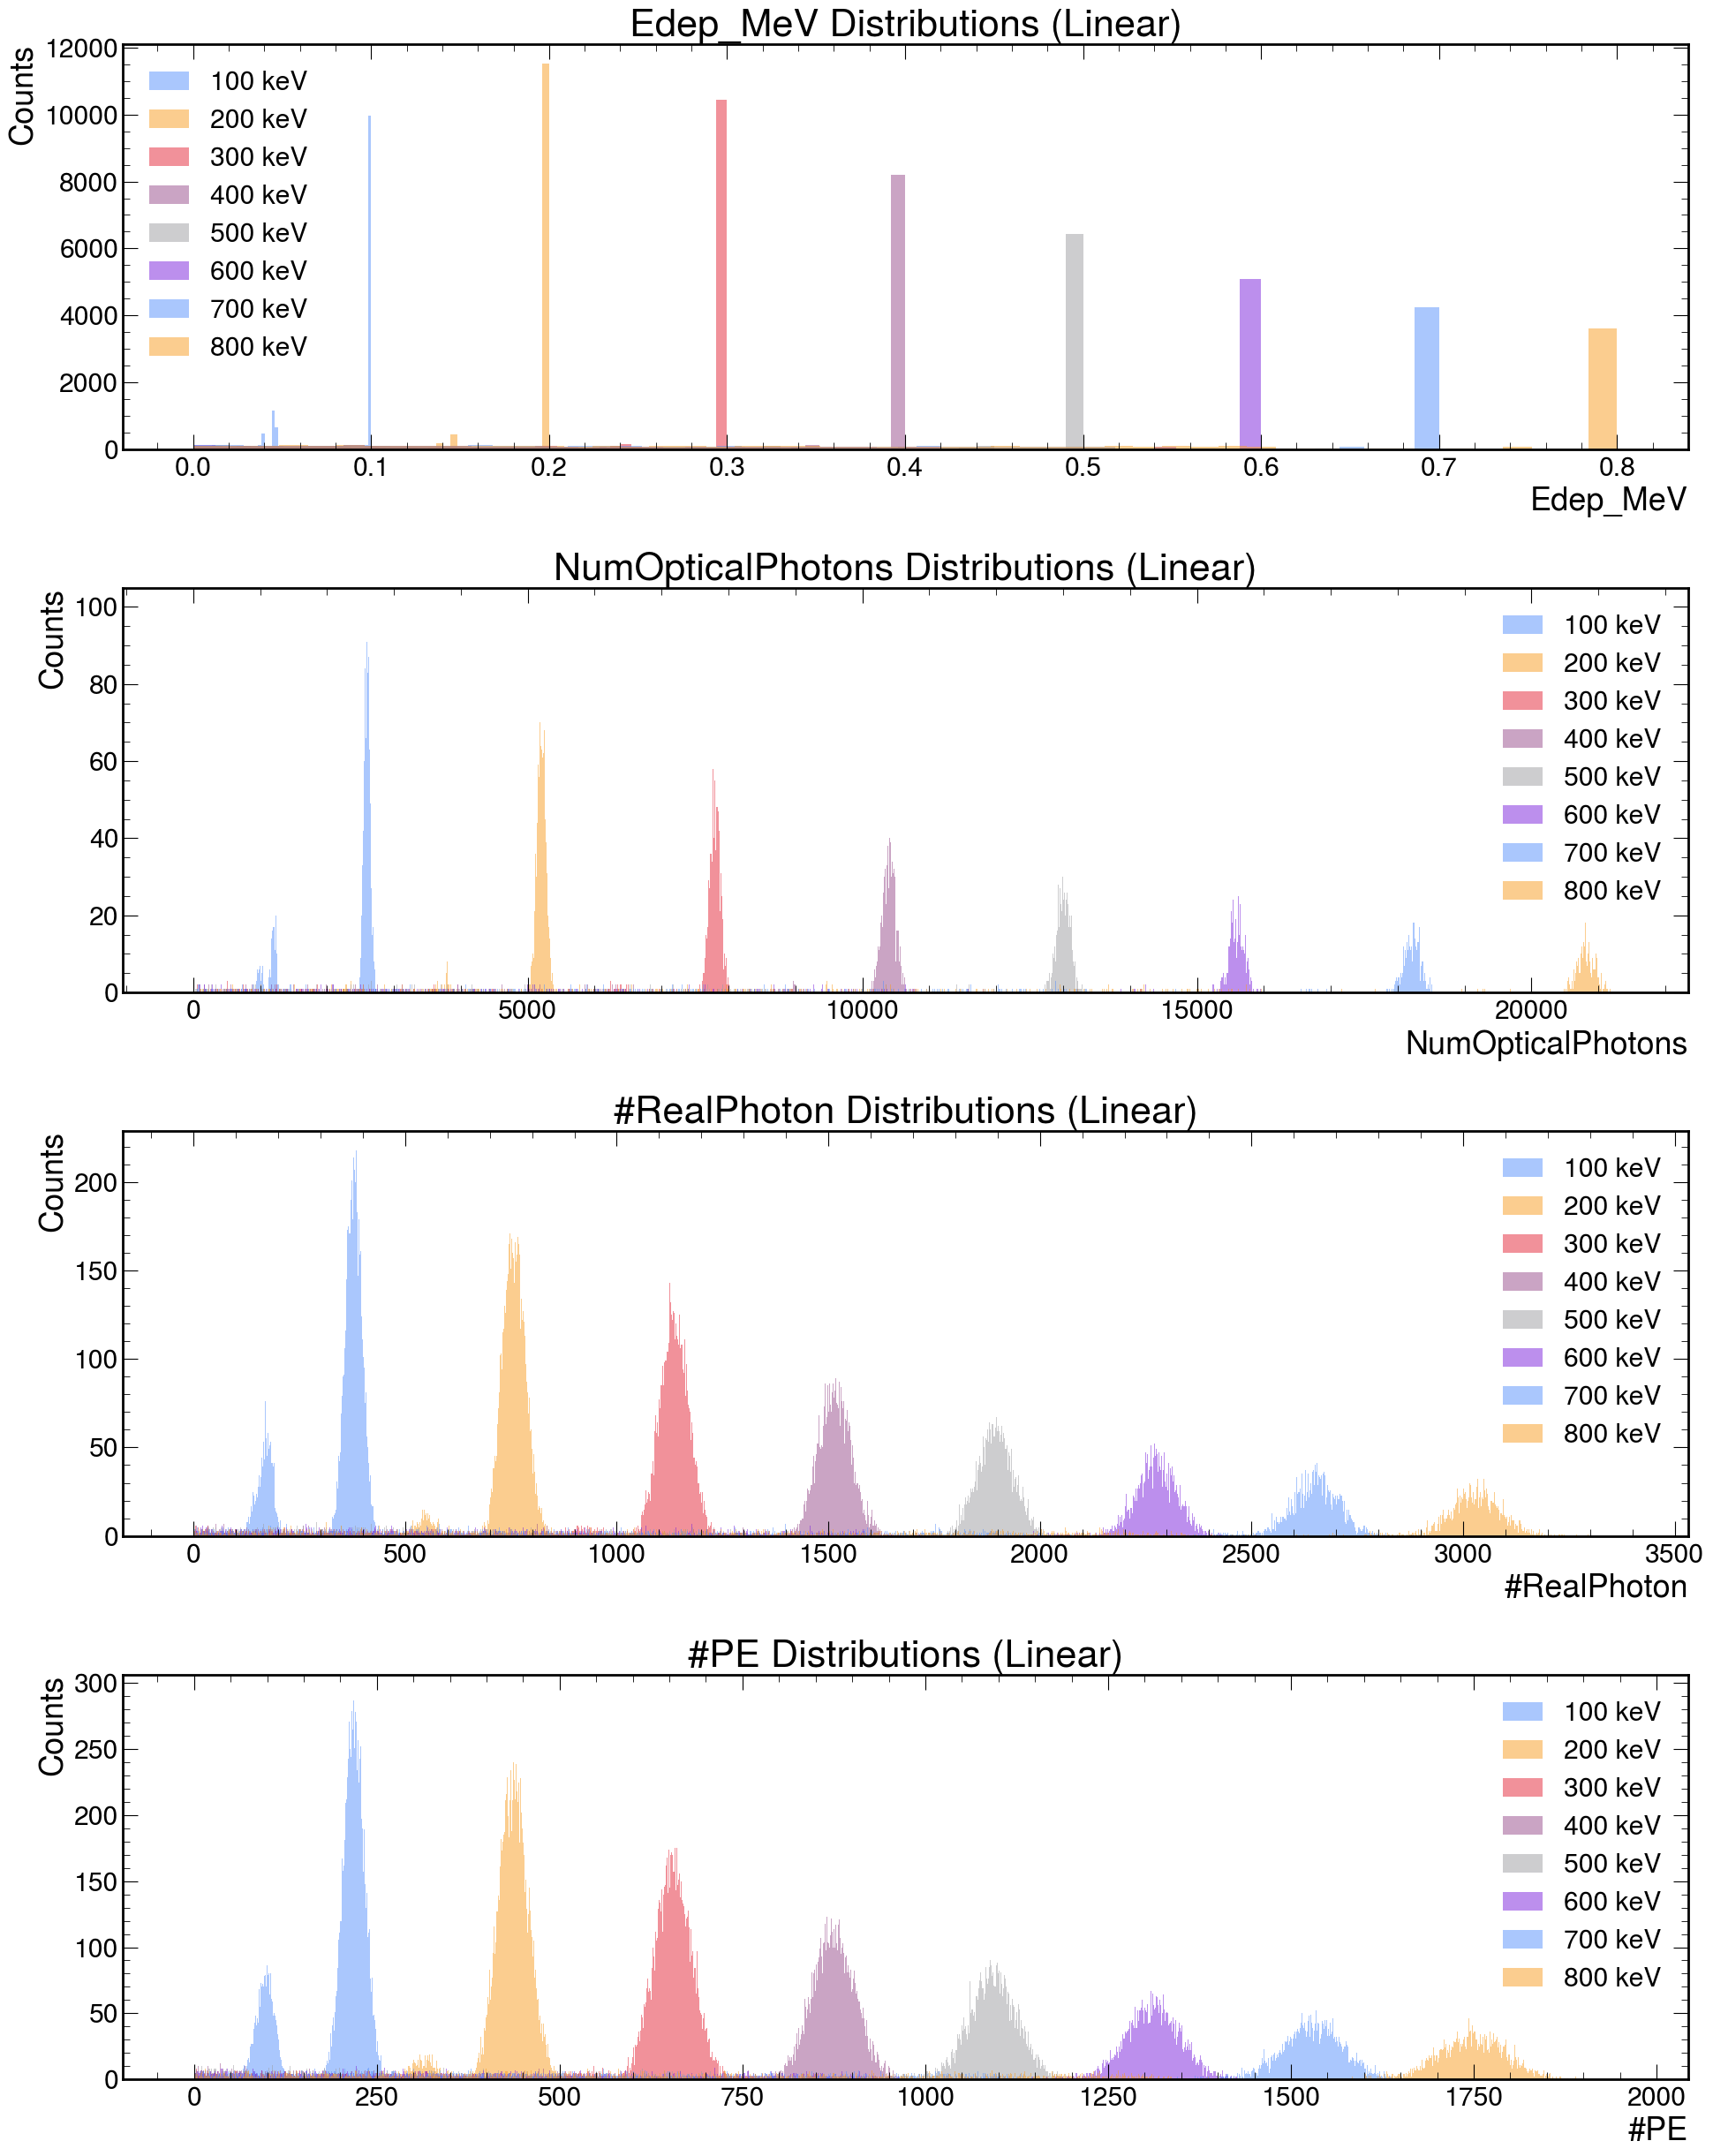

/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


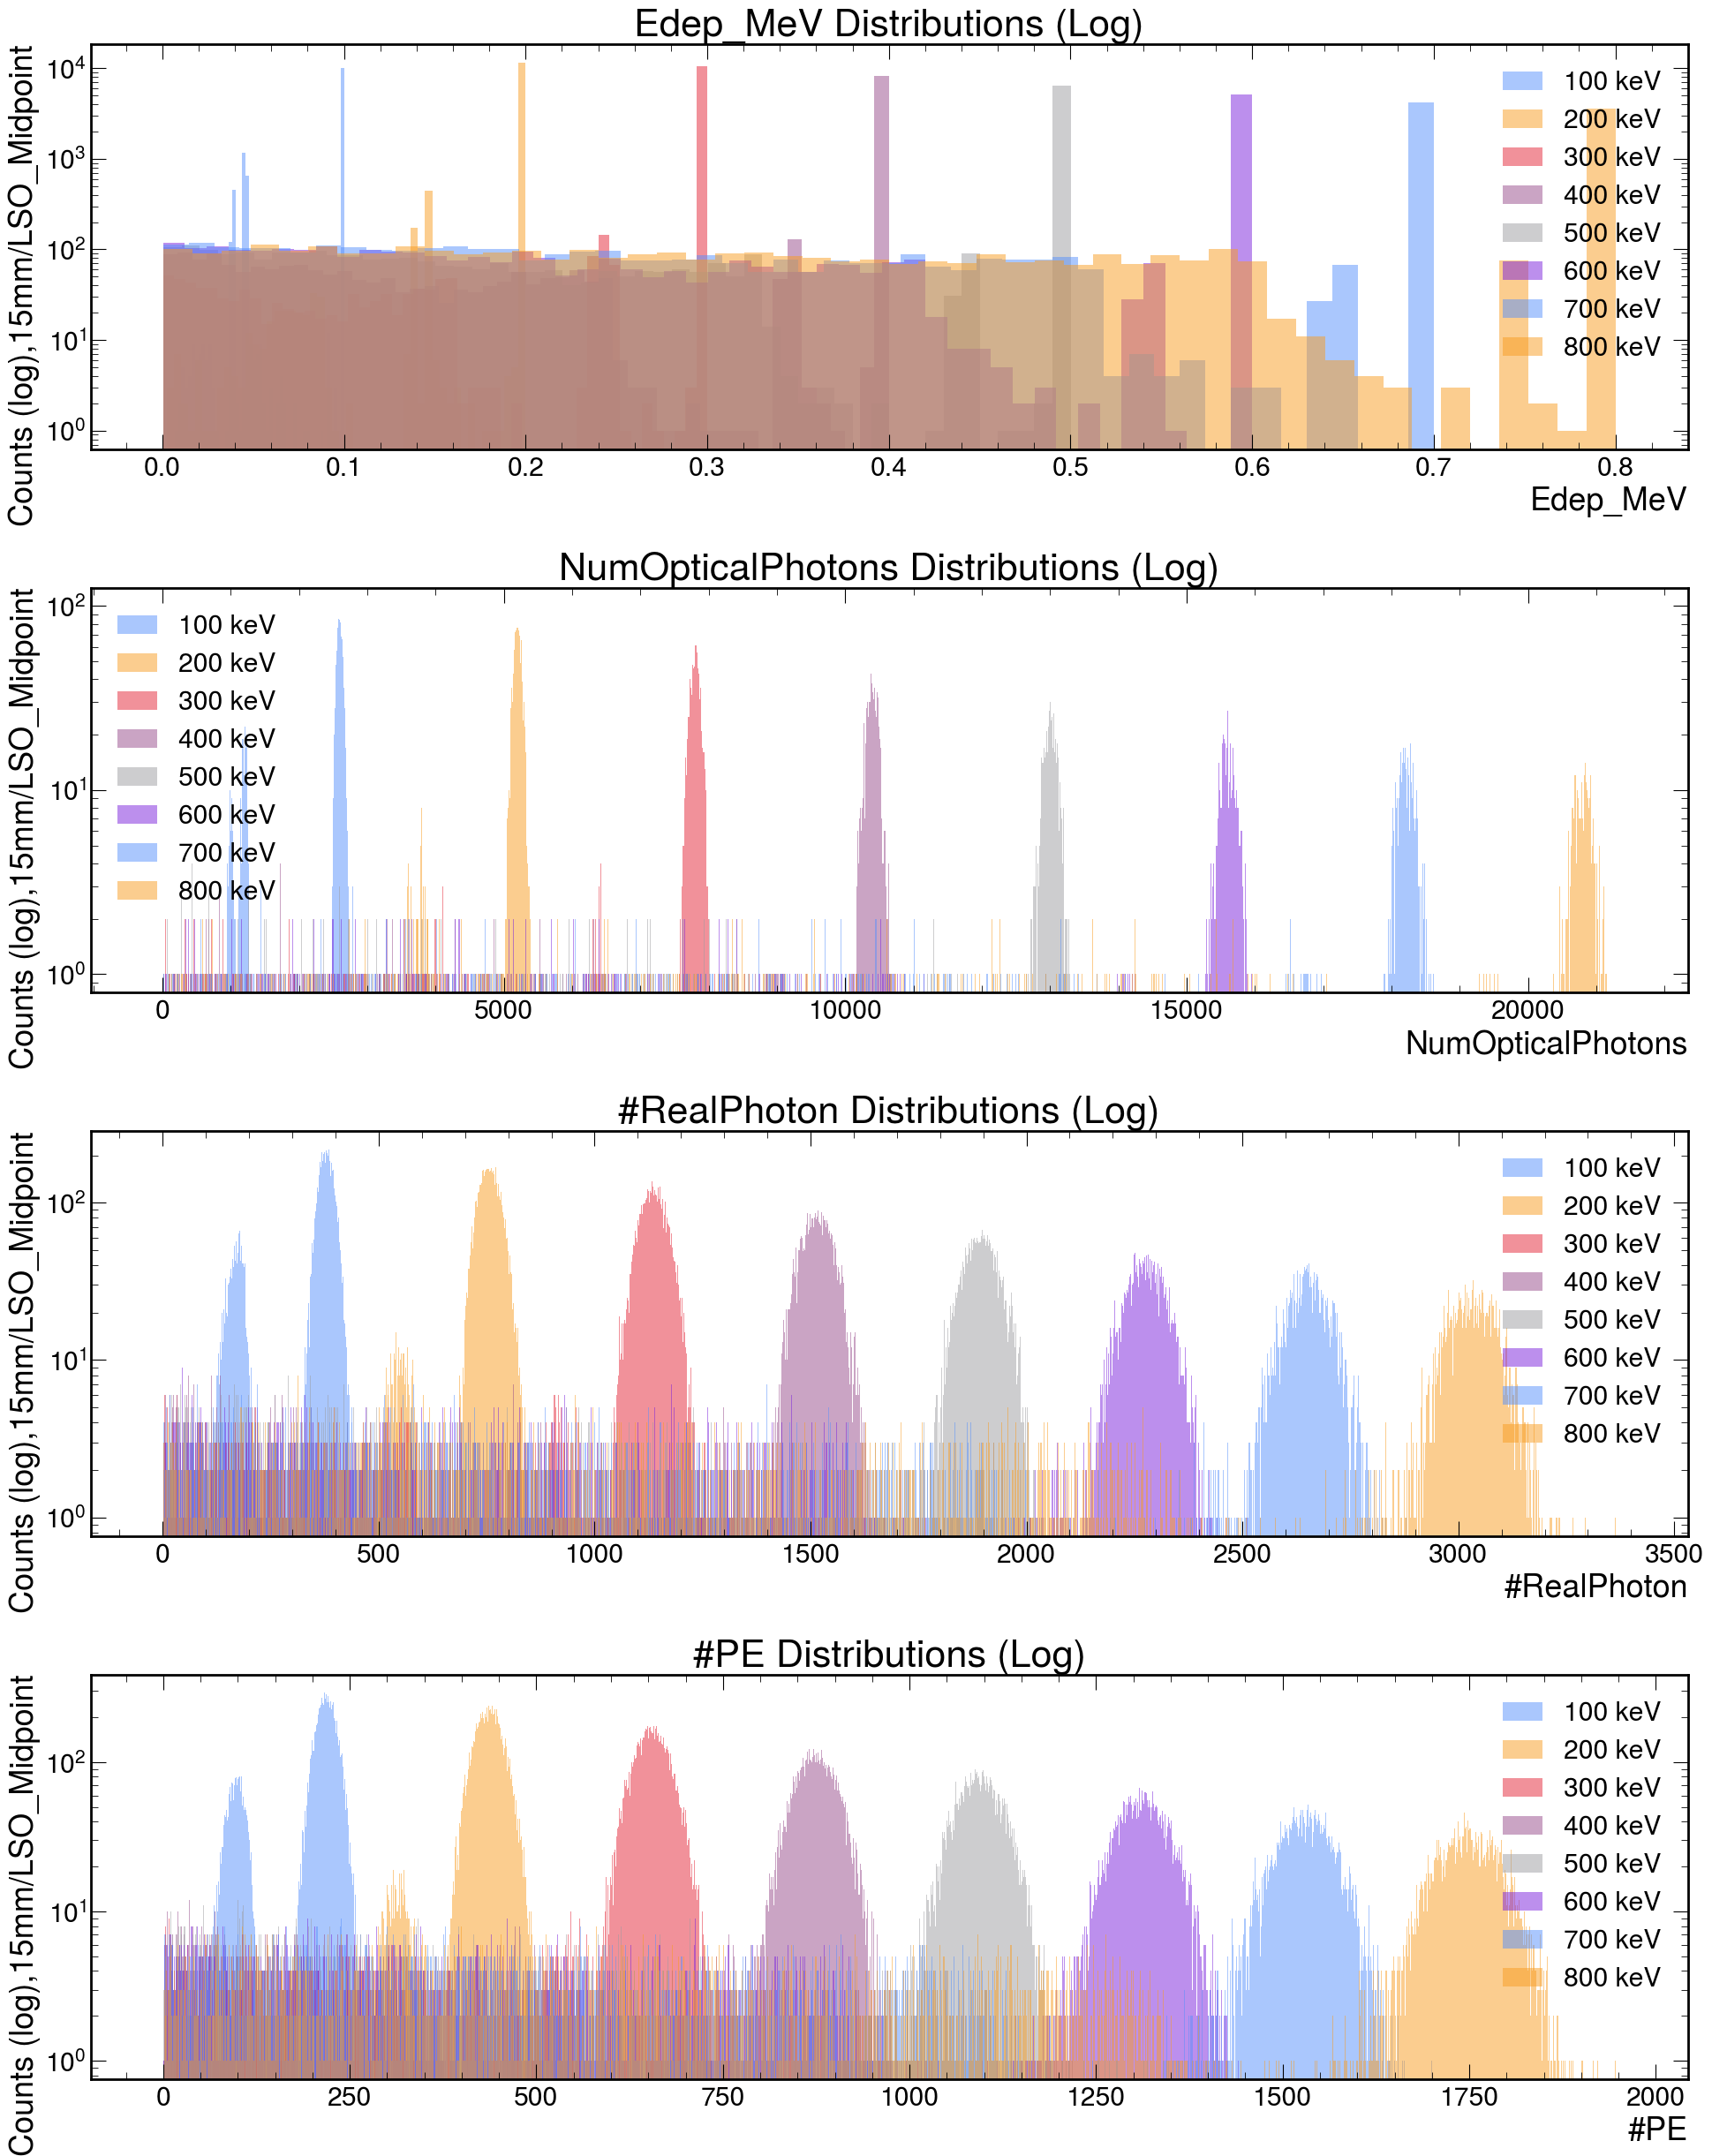

/tmp/ipykernel_114814/13027582.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.tight_layout()
/tmp/ipykernel_114814/13027582.py:109: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.savefig(dir_name + '/histograms_linear.png')
/tmp/ipykernel_114814/13027582.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.tight_layout()
/tmp/ipykernel_114814/13027582.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.savefig(dir_name + '/histograms_log.png')
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


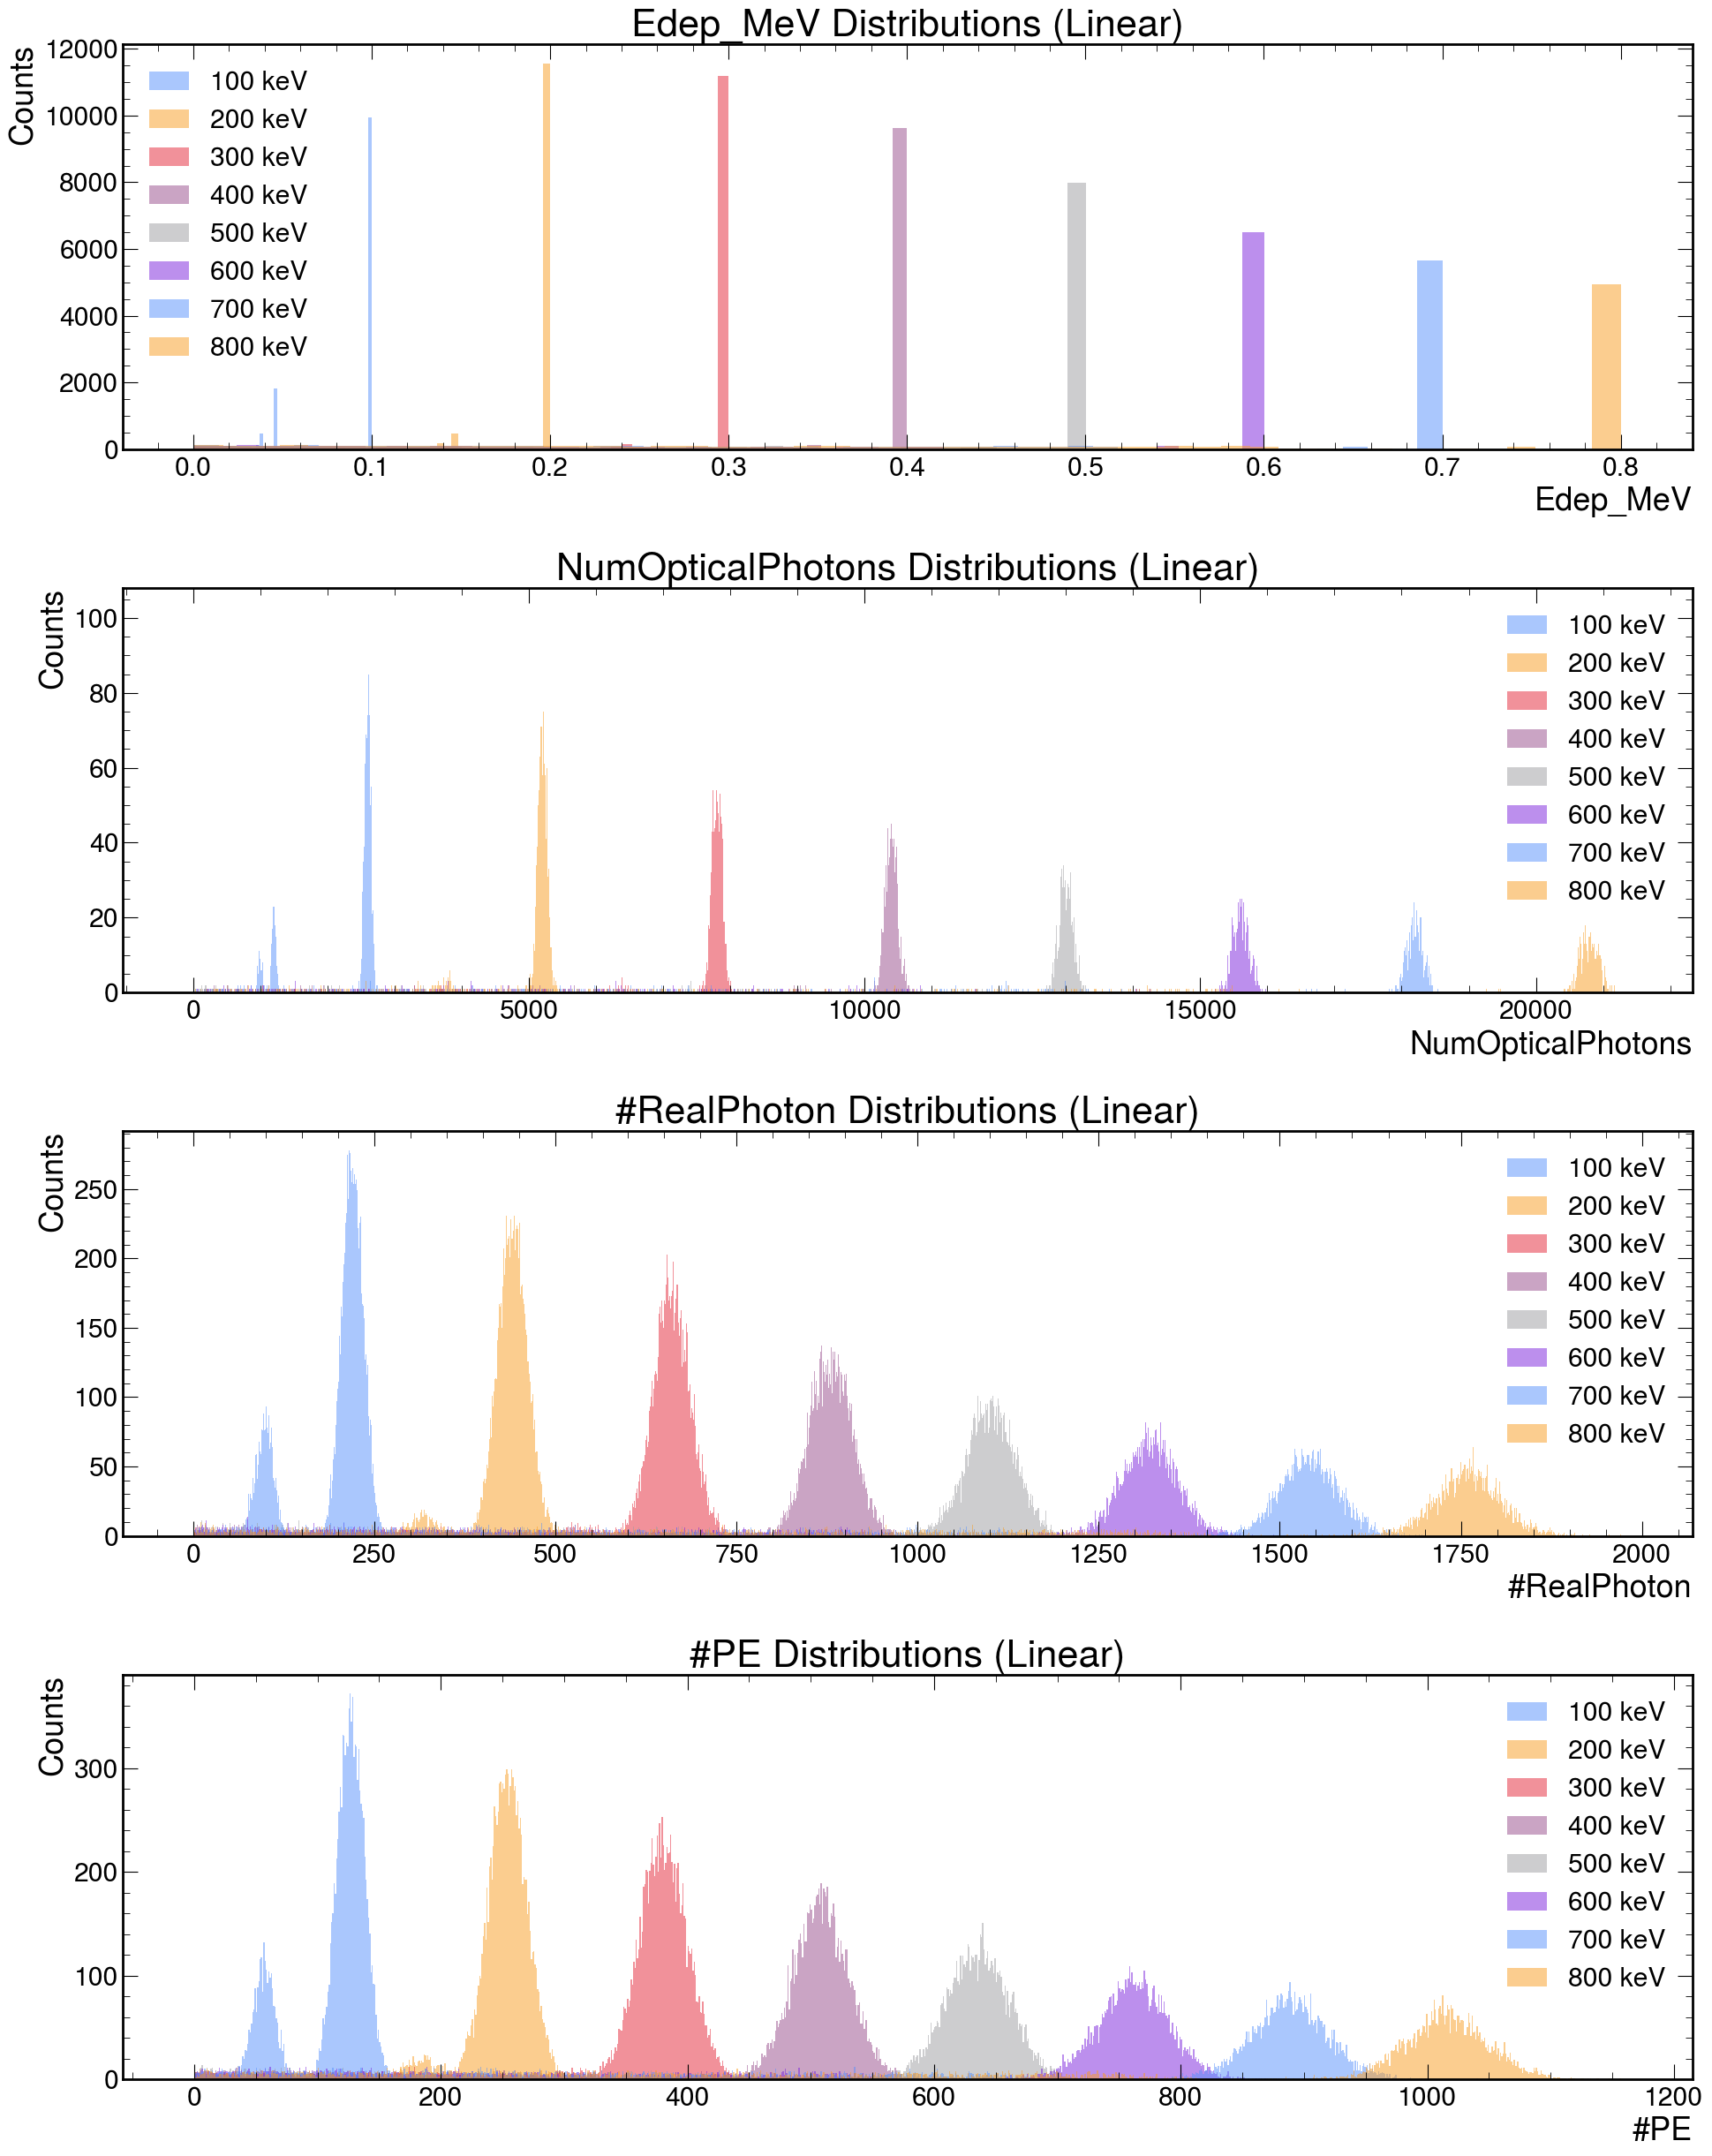

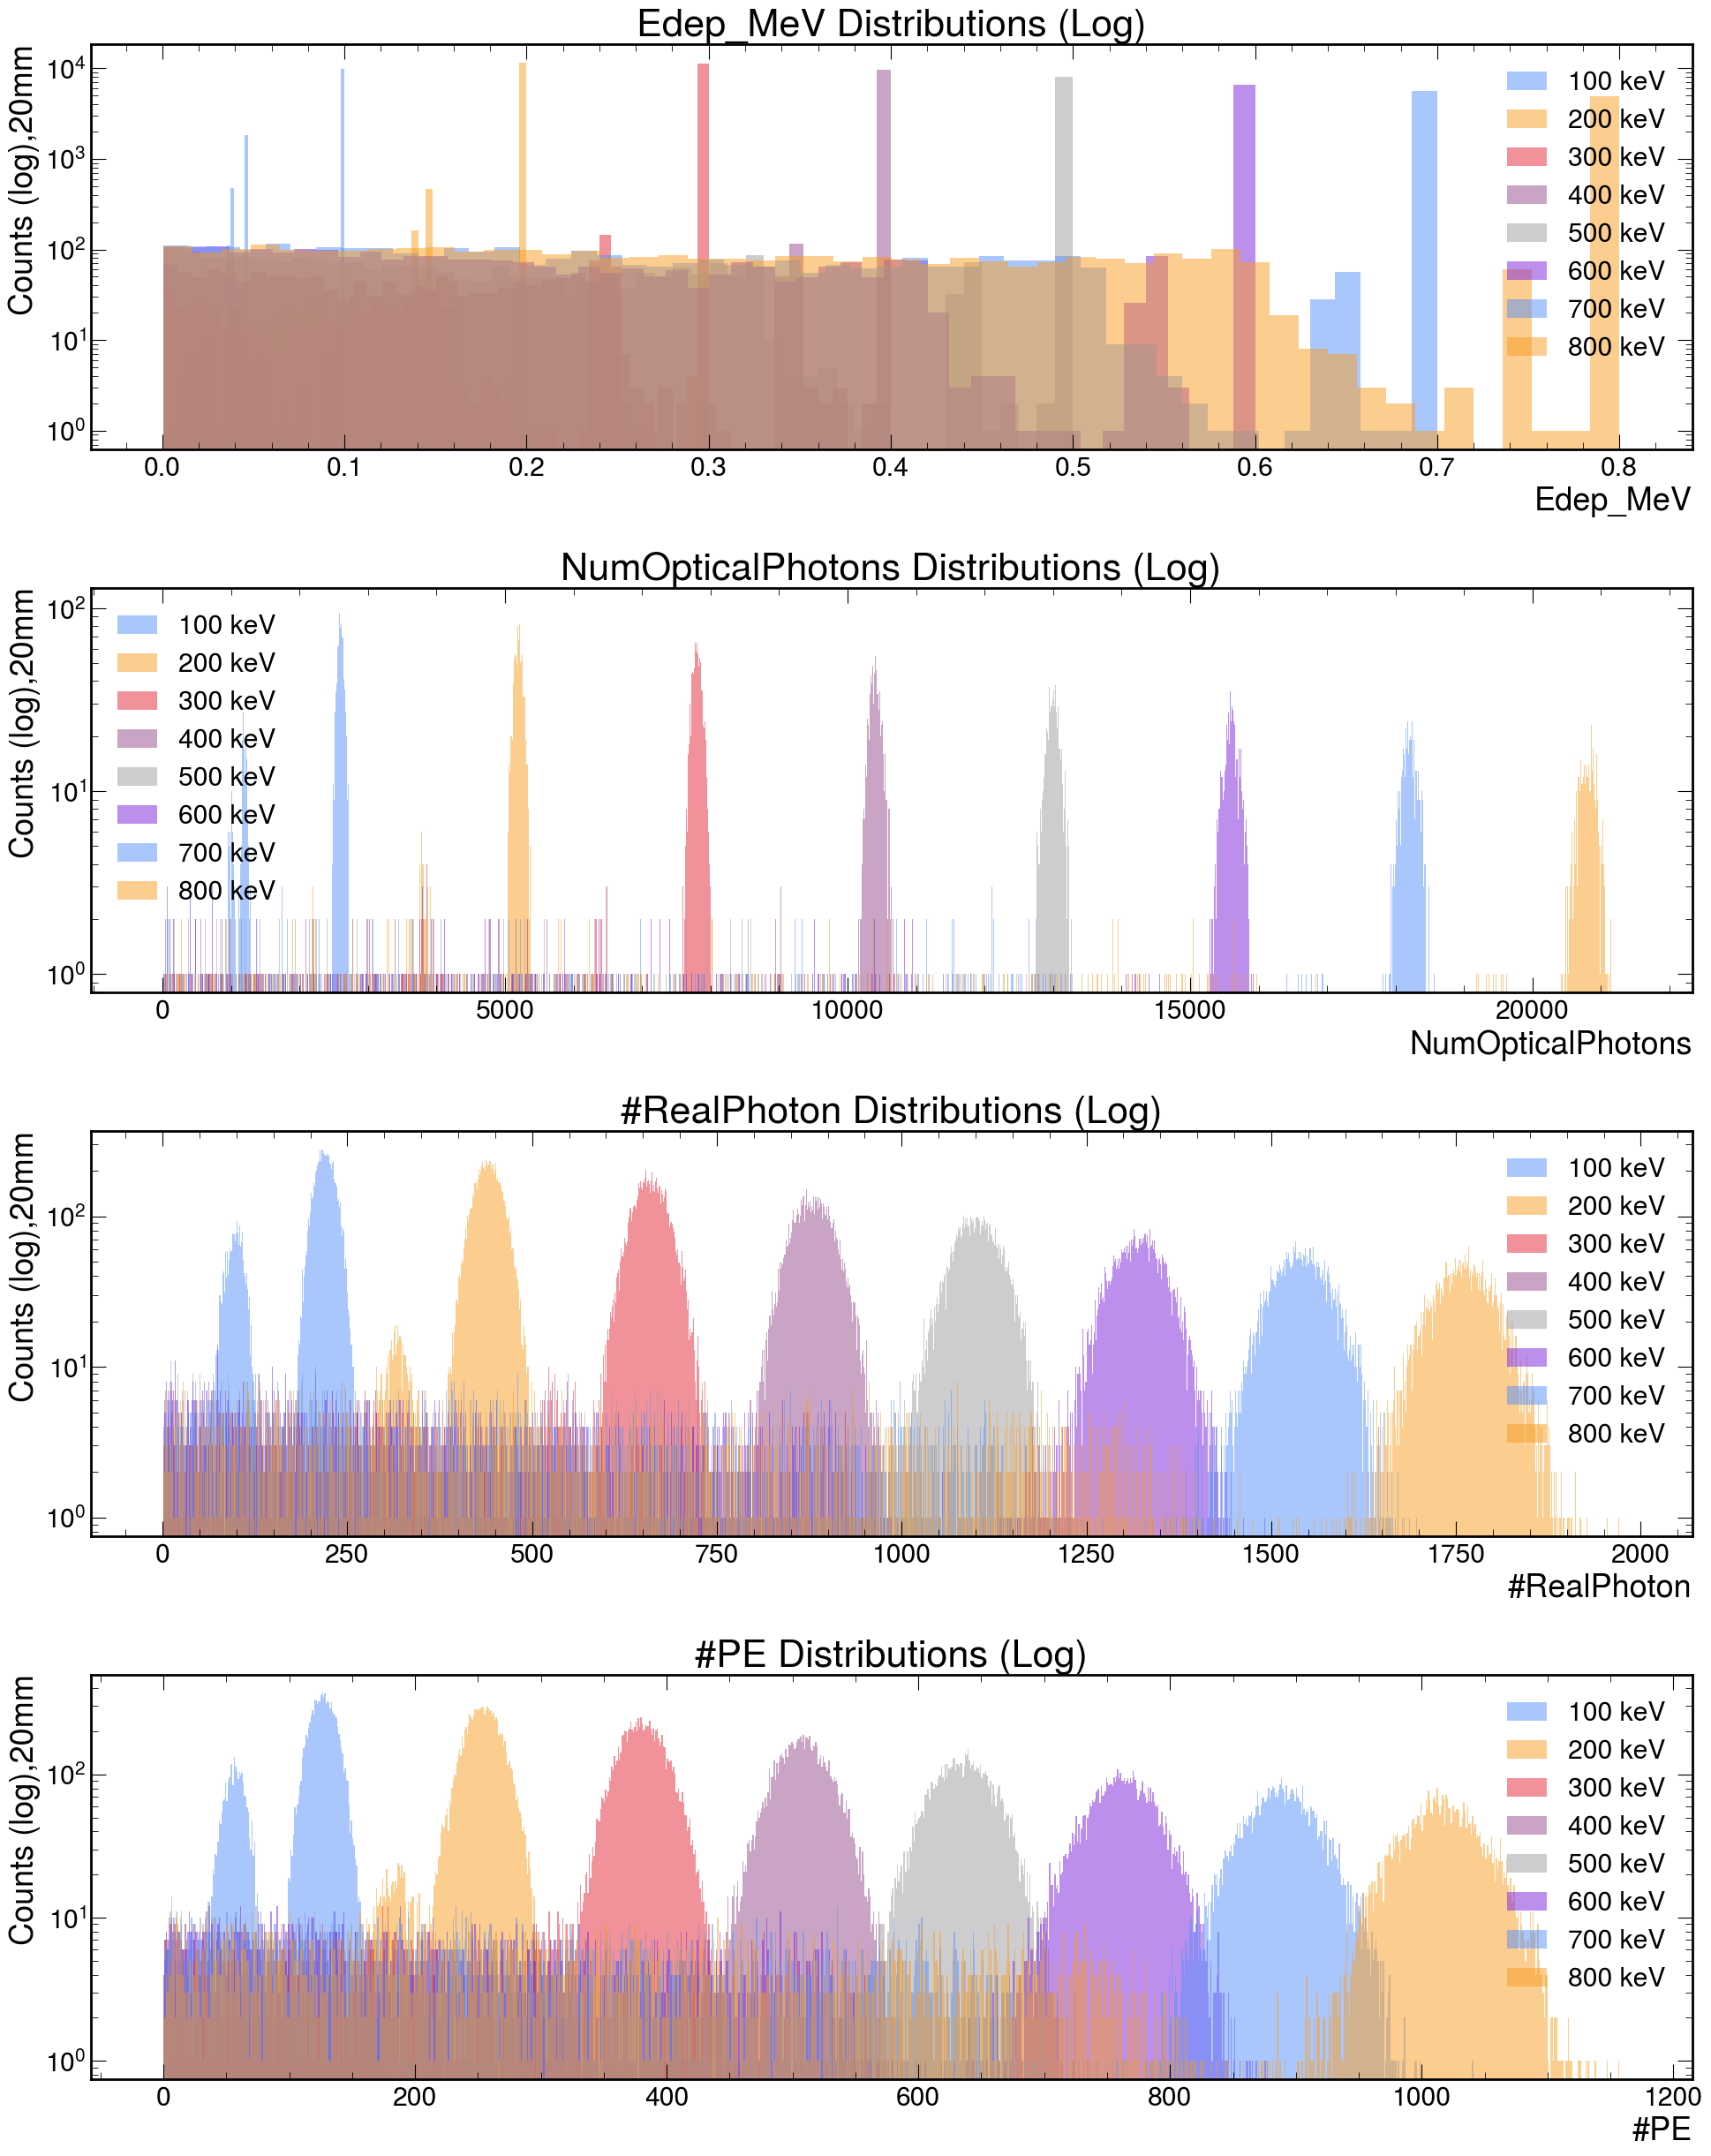

/tmp/ipykernel_114814/13027582.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.tight_layout()
/tmp/ipykernel_114814/13027582.py:109: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.savefig(dir_name + '/histograms_linear.png')
/tmp/ipykernel_114814/13027582.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.tight_layout()
/tmp/ipykernel_114814/13027582.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.savefig(dir_name + '/histograms_log.png')
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


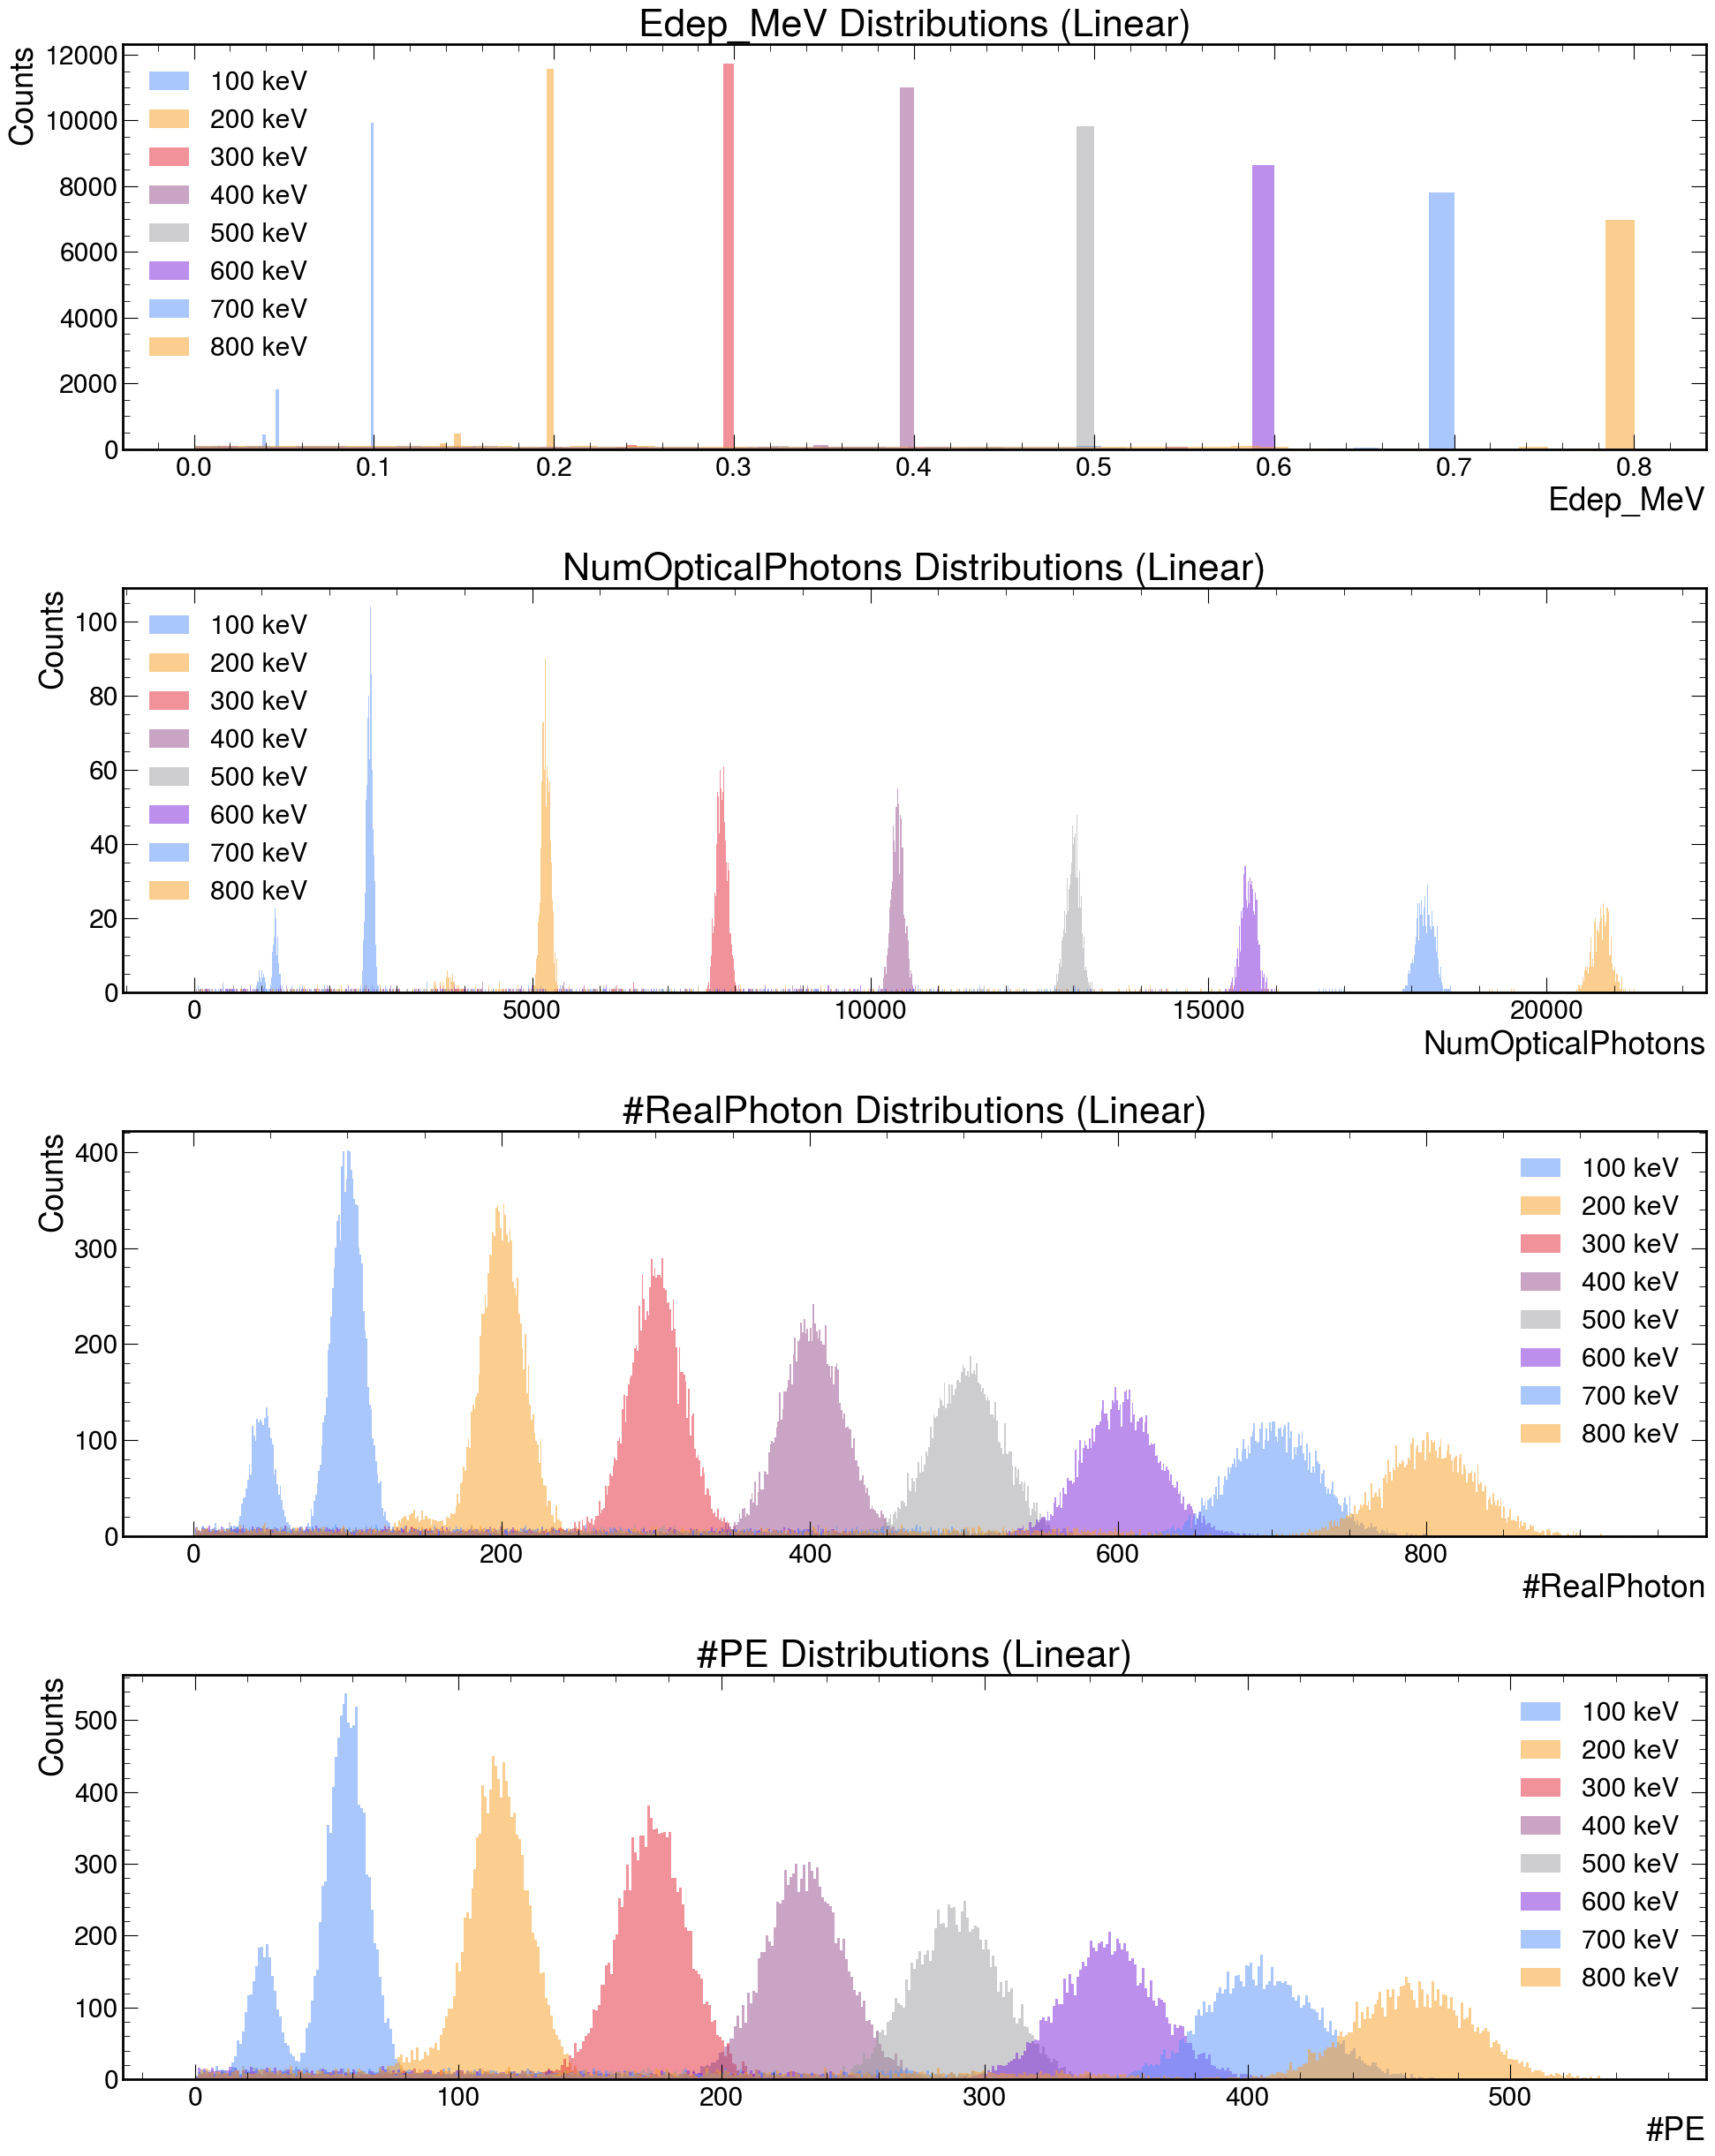

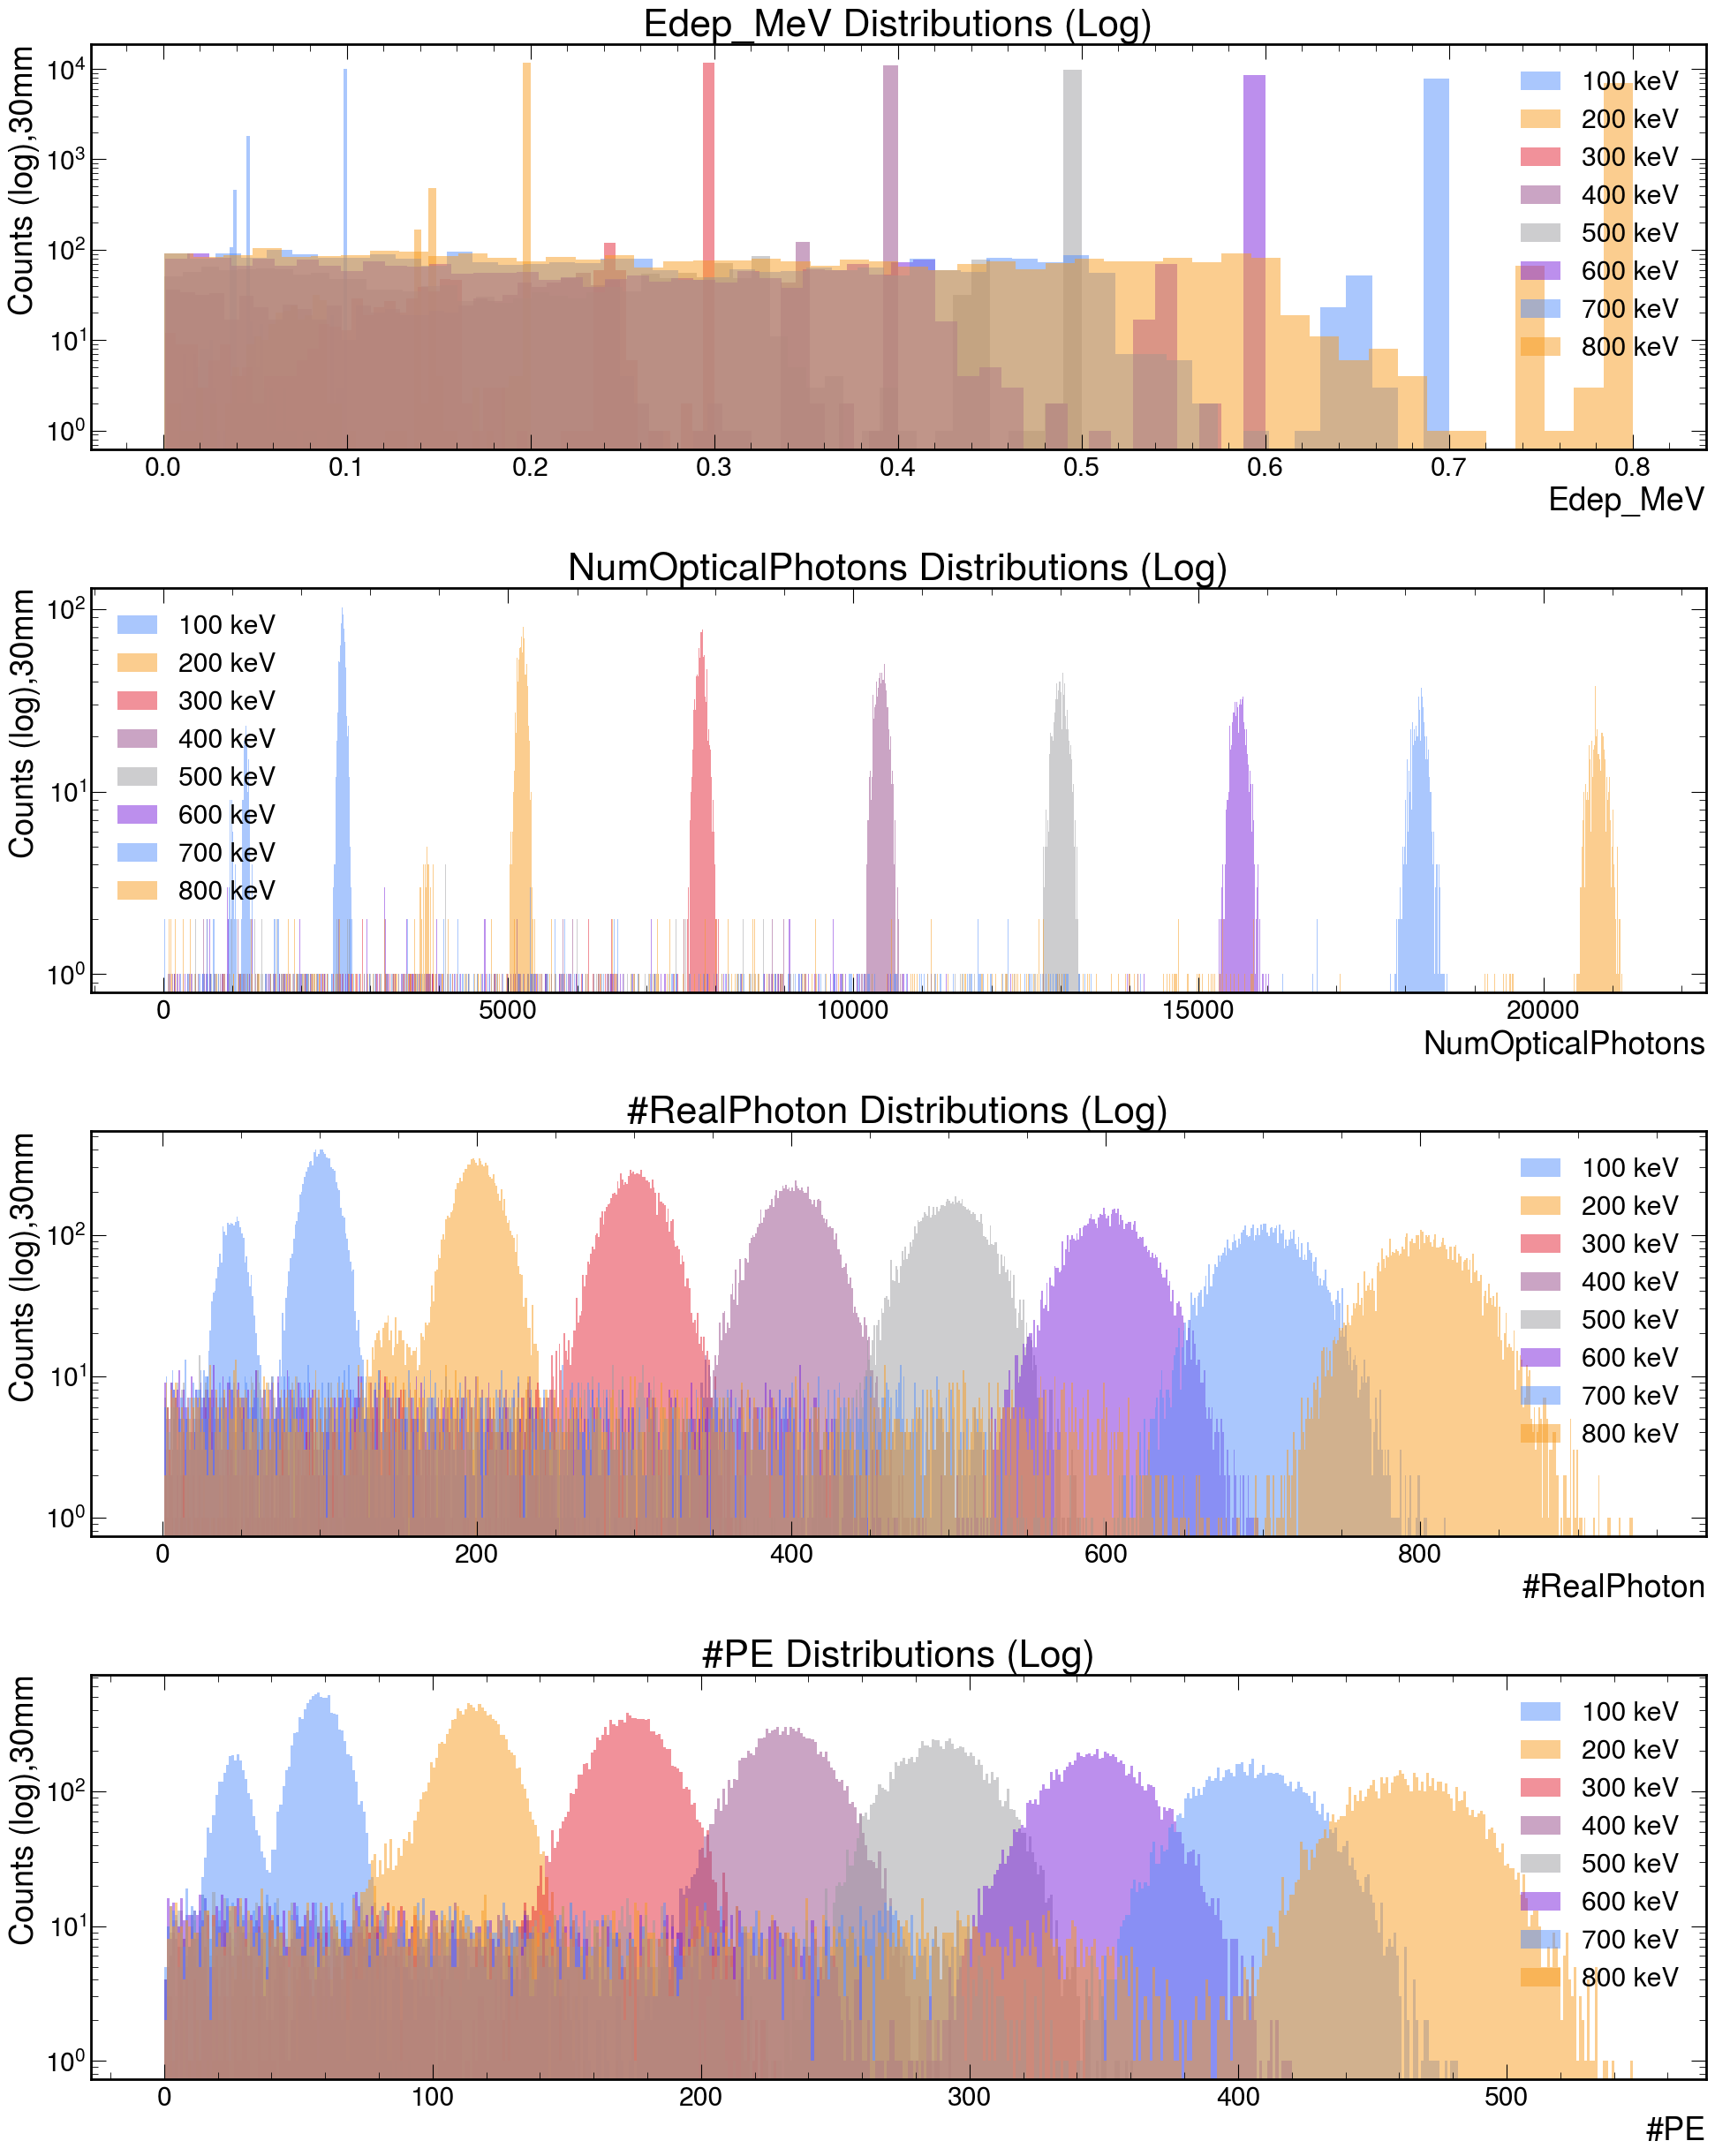

/tmp/ipykernel_114814/13027582.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.tight_layout()
/tmp/ipykernel_114814/13027582.py:109: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.savefig(dir_name + '/histograms_linear.png')
/tmp/ipykernel_114814/13027582.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.tight_layout()
/tmp/ipykernel_114814/13027582.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.savefig(dir_name + '/histograms_log.png')
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


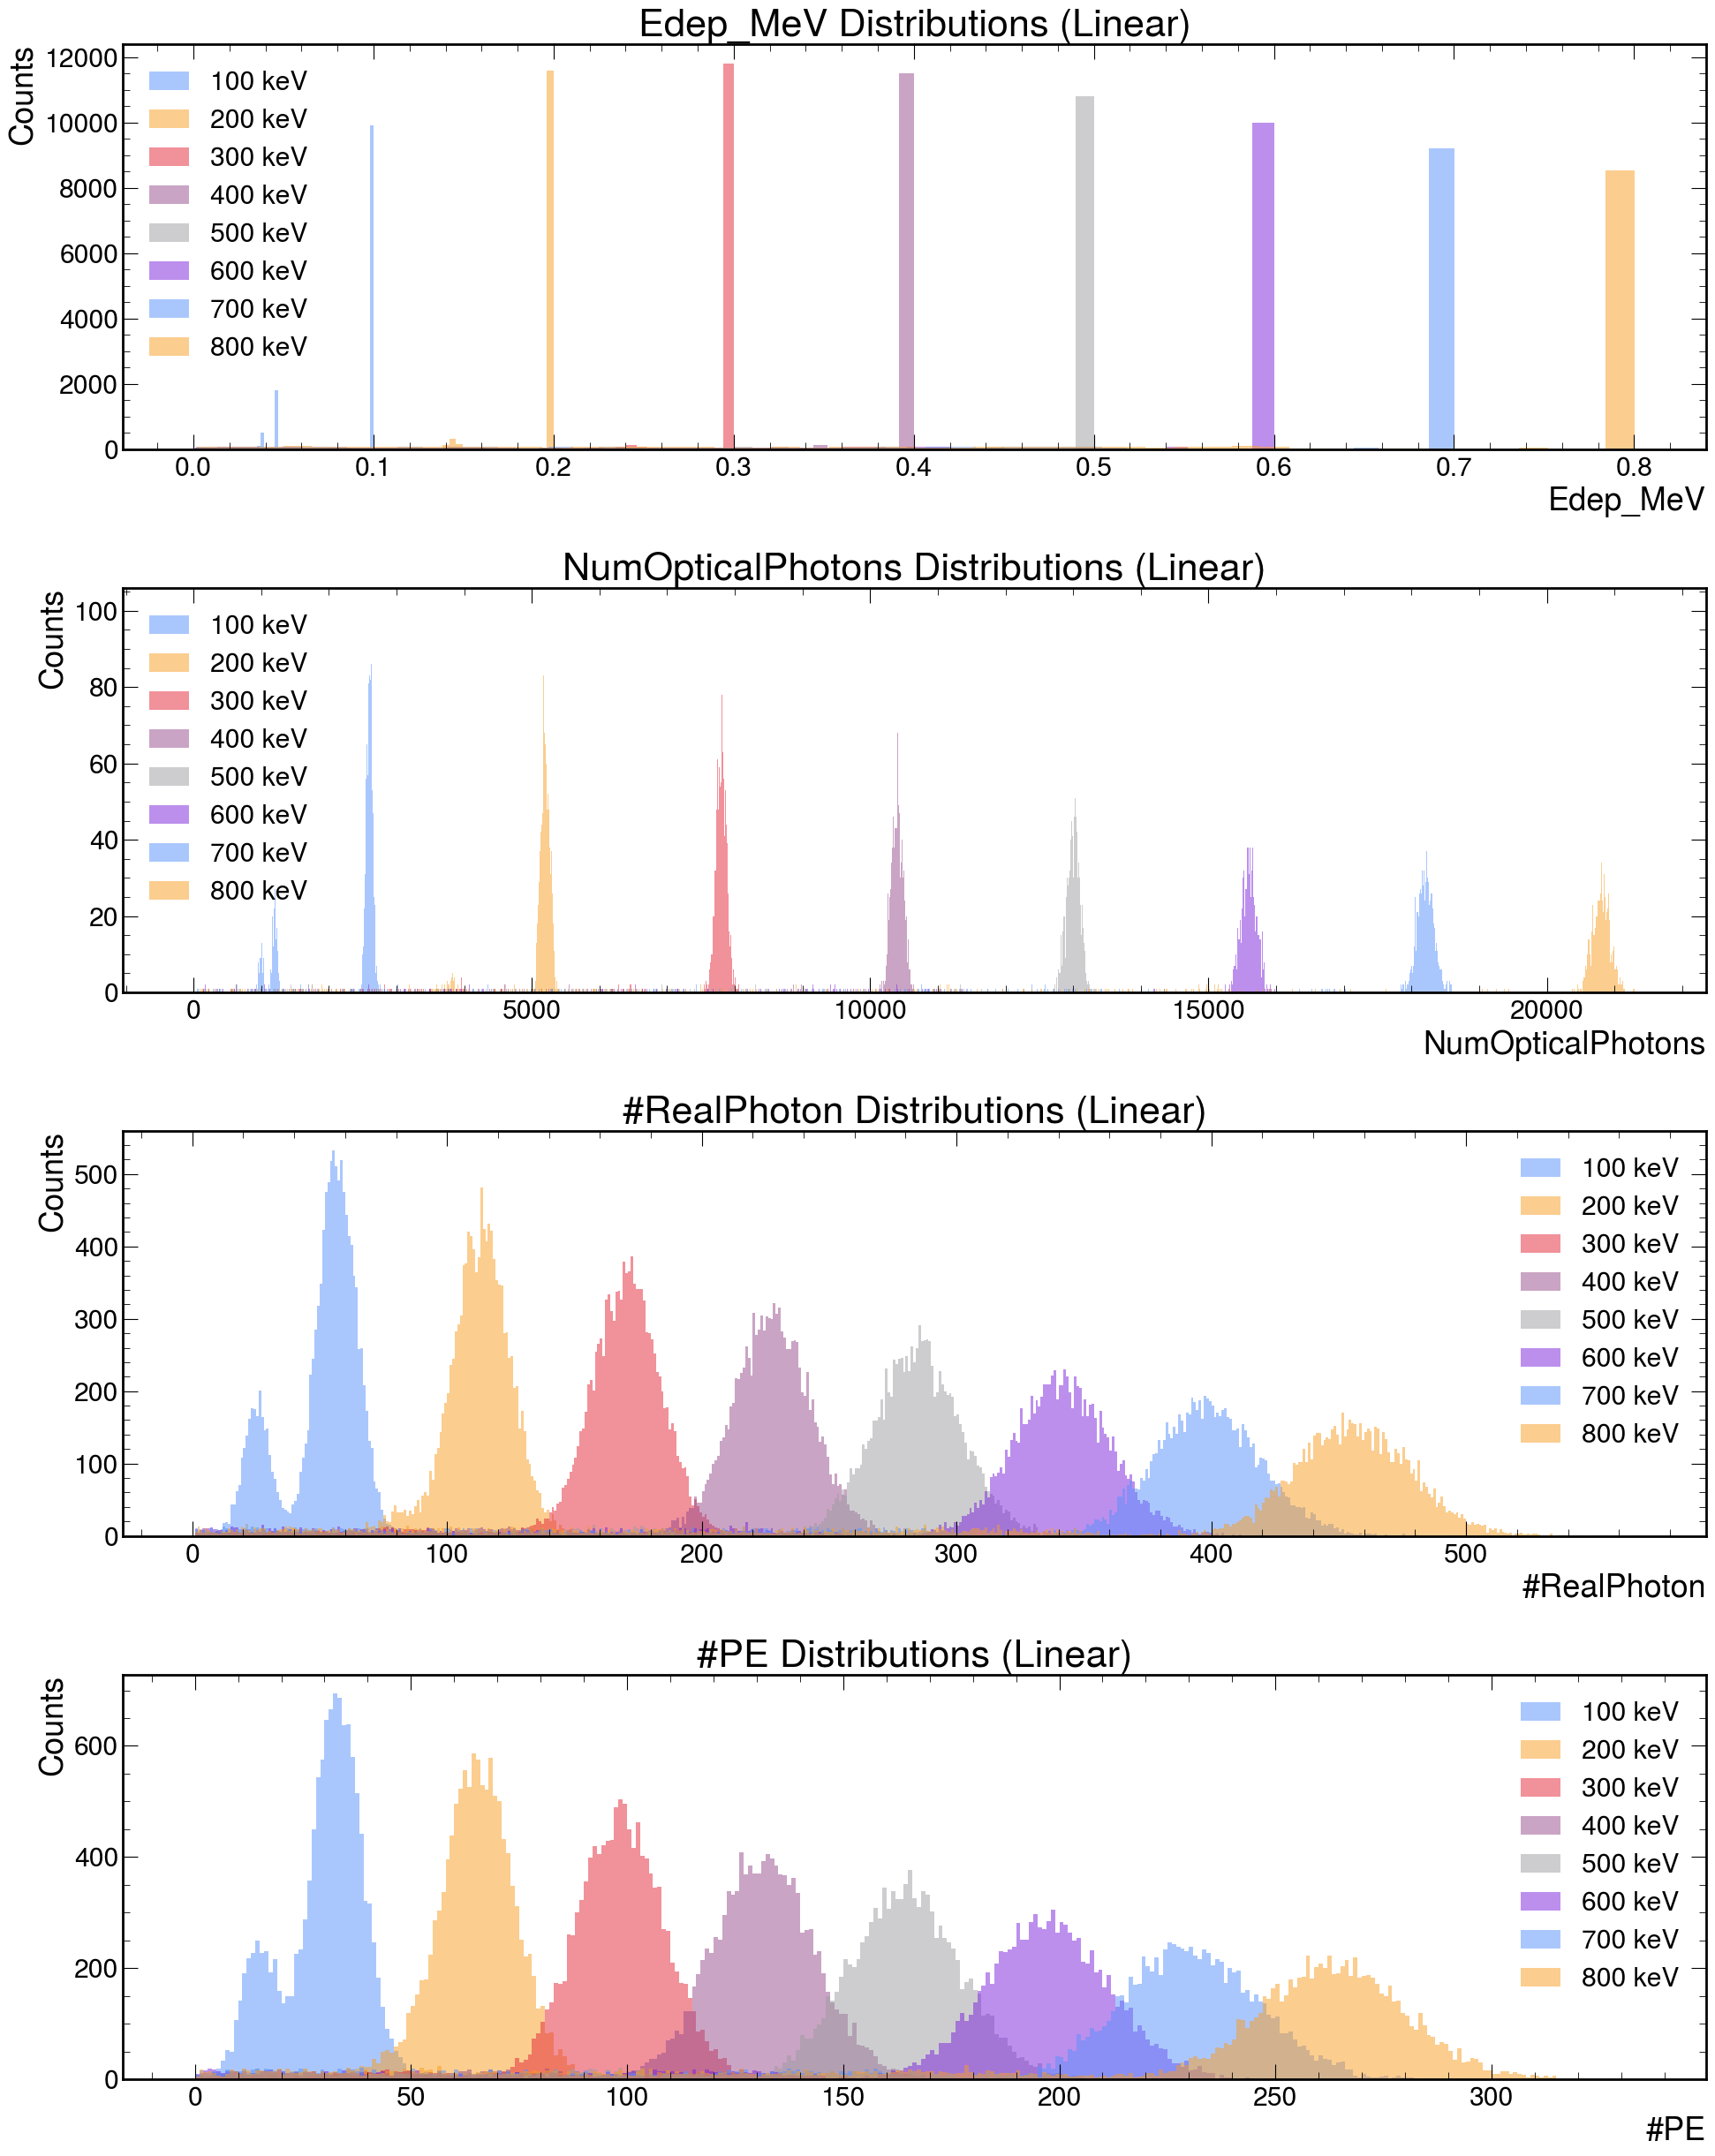

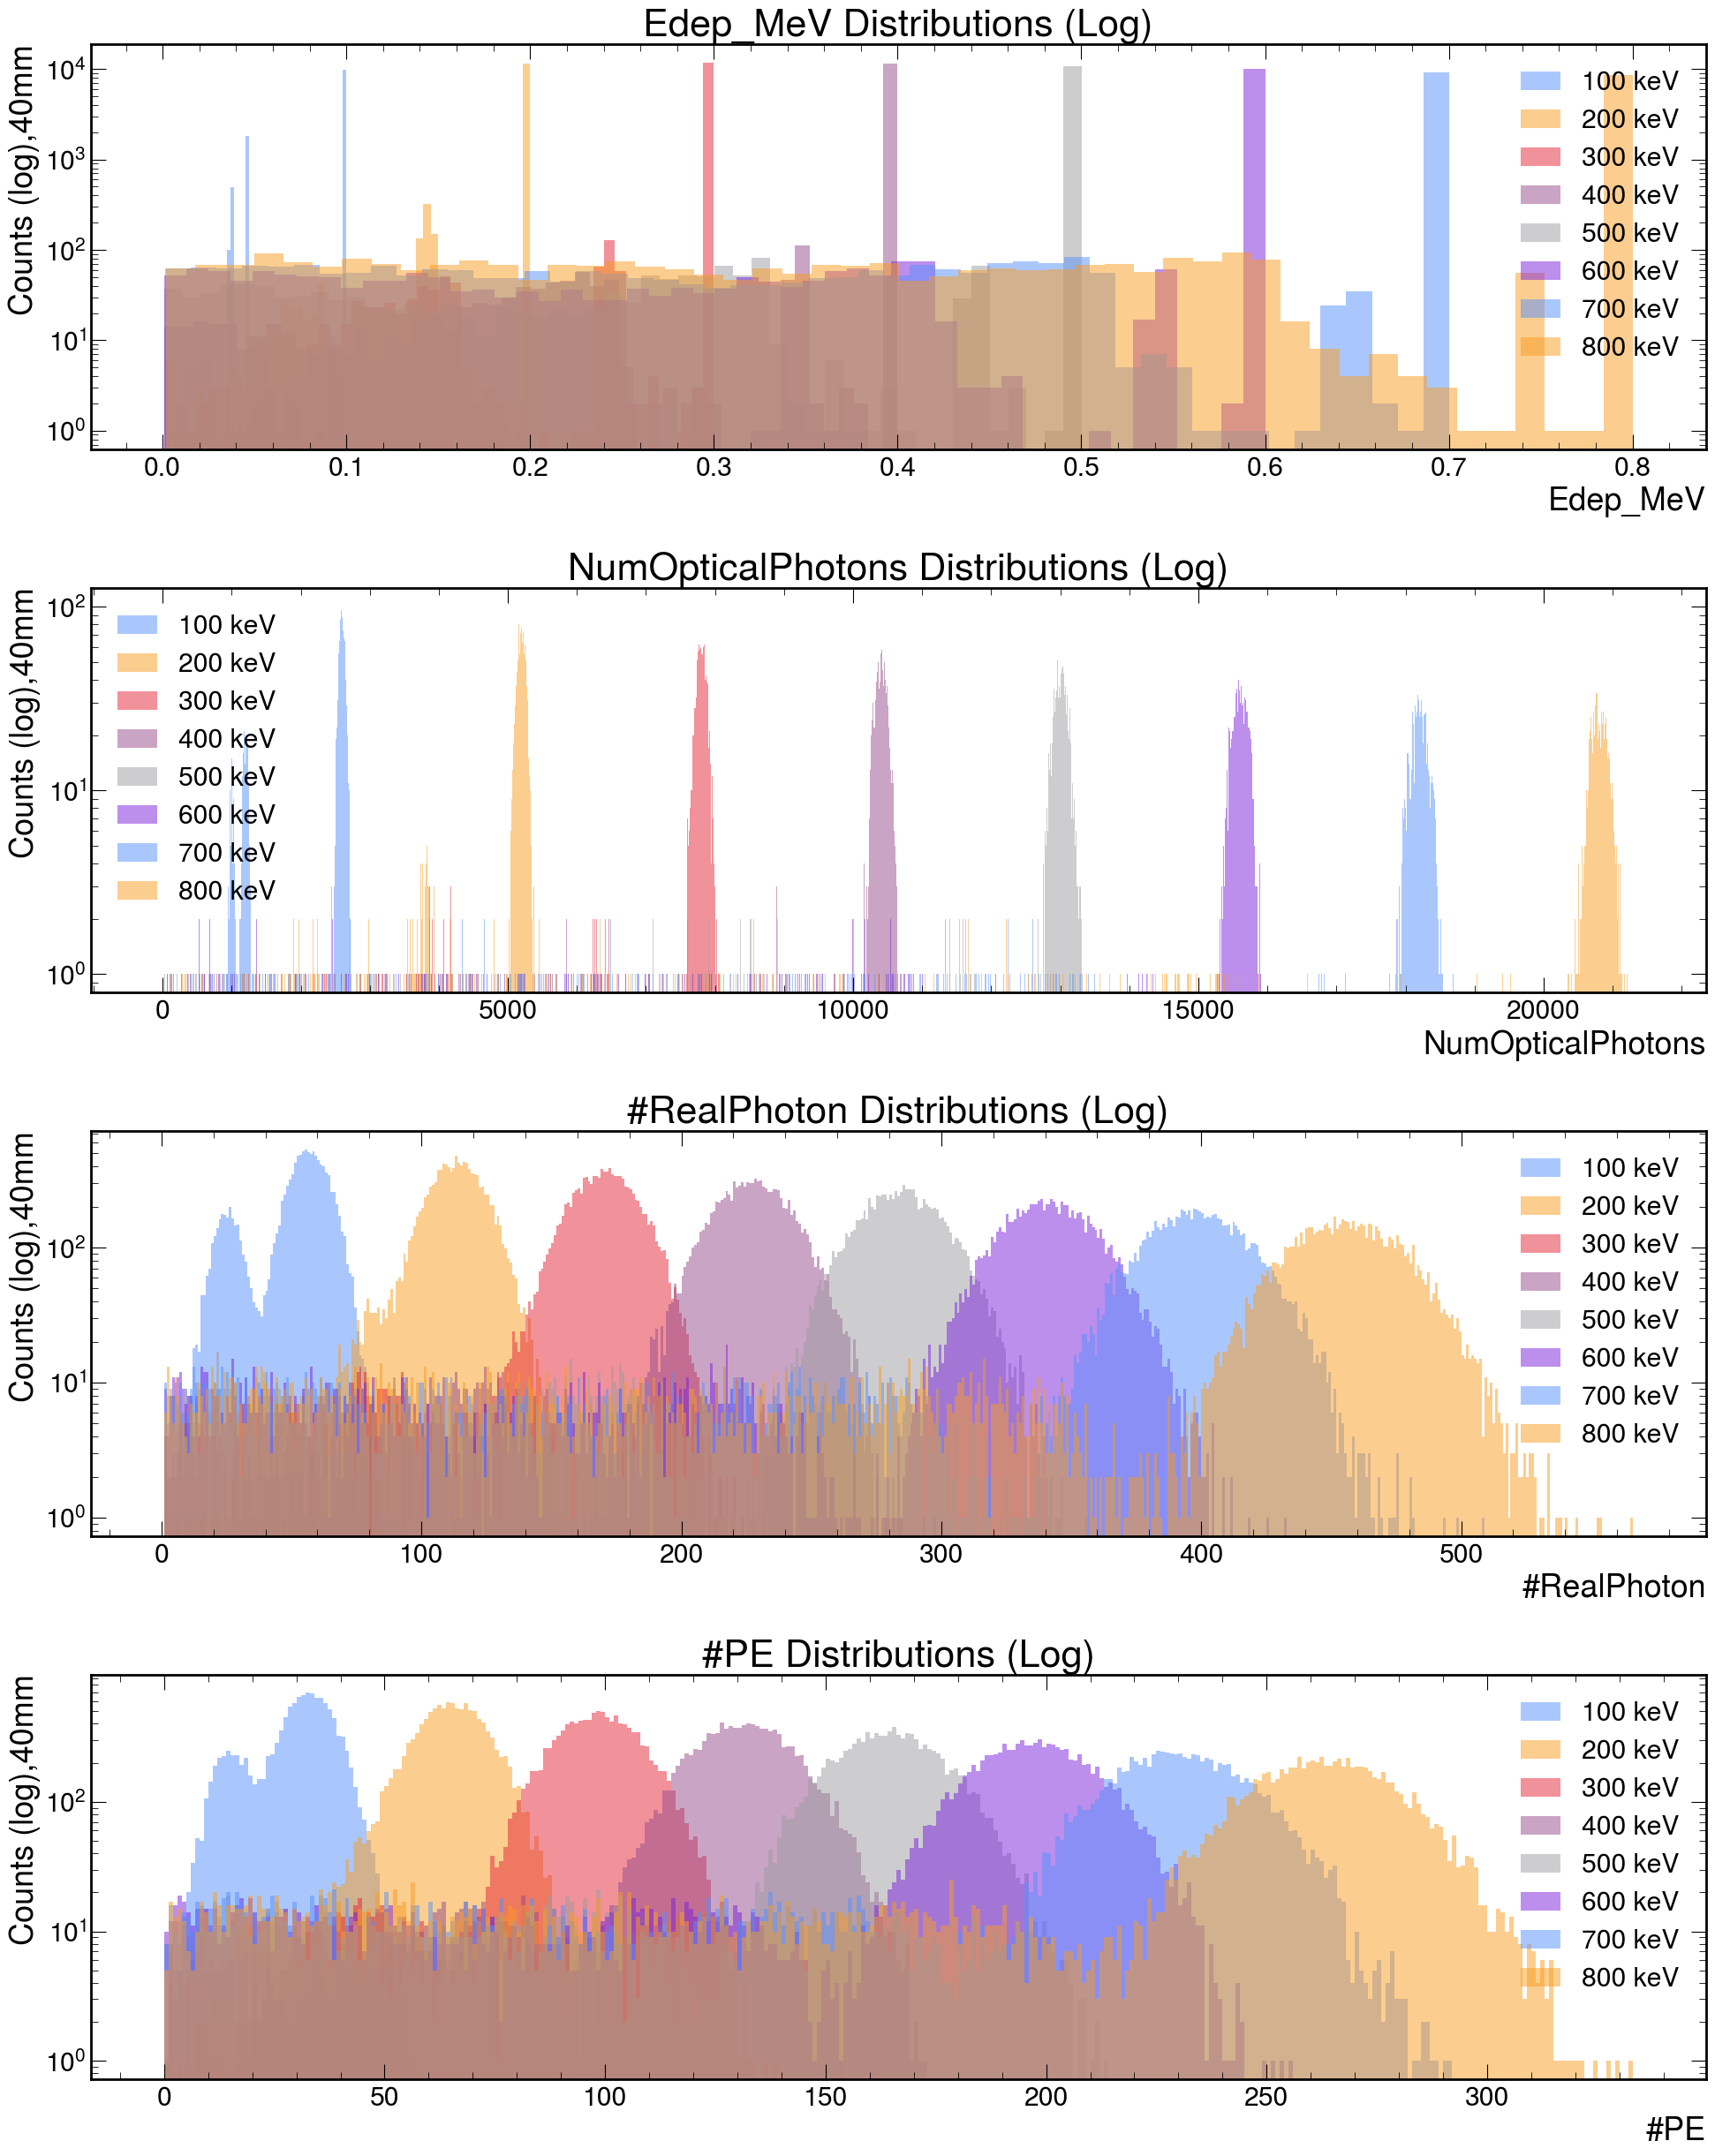

/tmp/ipykernel_114814/13027582.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.tight_layout()
/tmp/ipykernel_114814/13027582.py:109: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.savefig(dir_name + '/histograms_linear.png')
/tmp/ipykernel_114814/13027582.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.tight_layout()
/tmp/ipykernel_114814/13027582.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.savefig(dir_name + '/histograms_log.png')
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


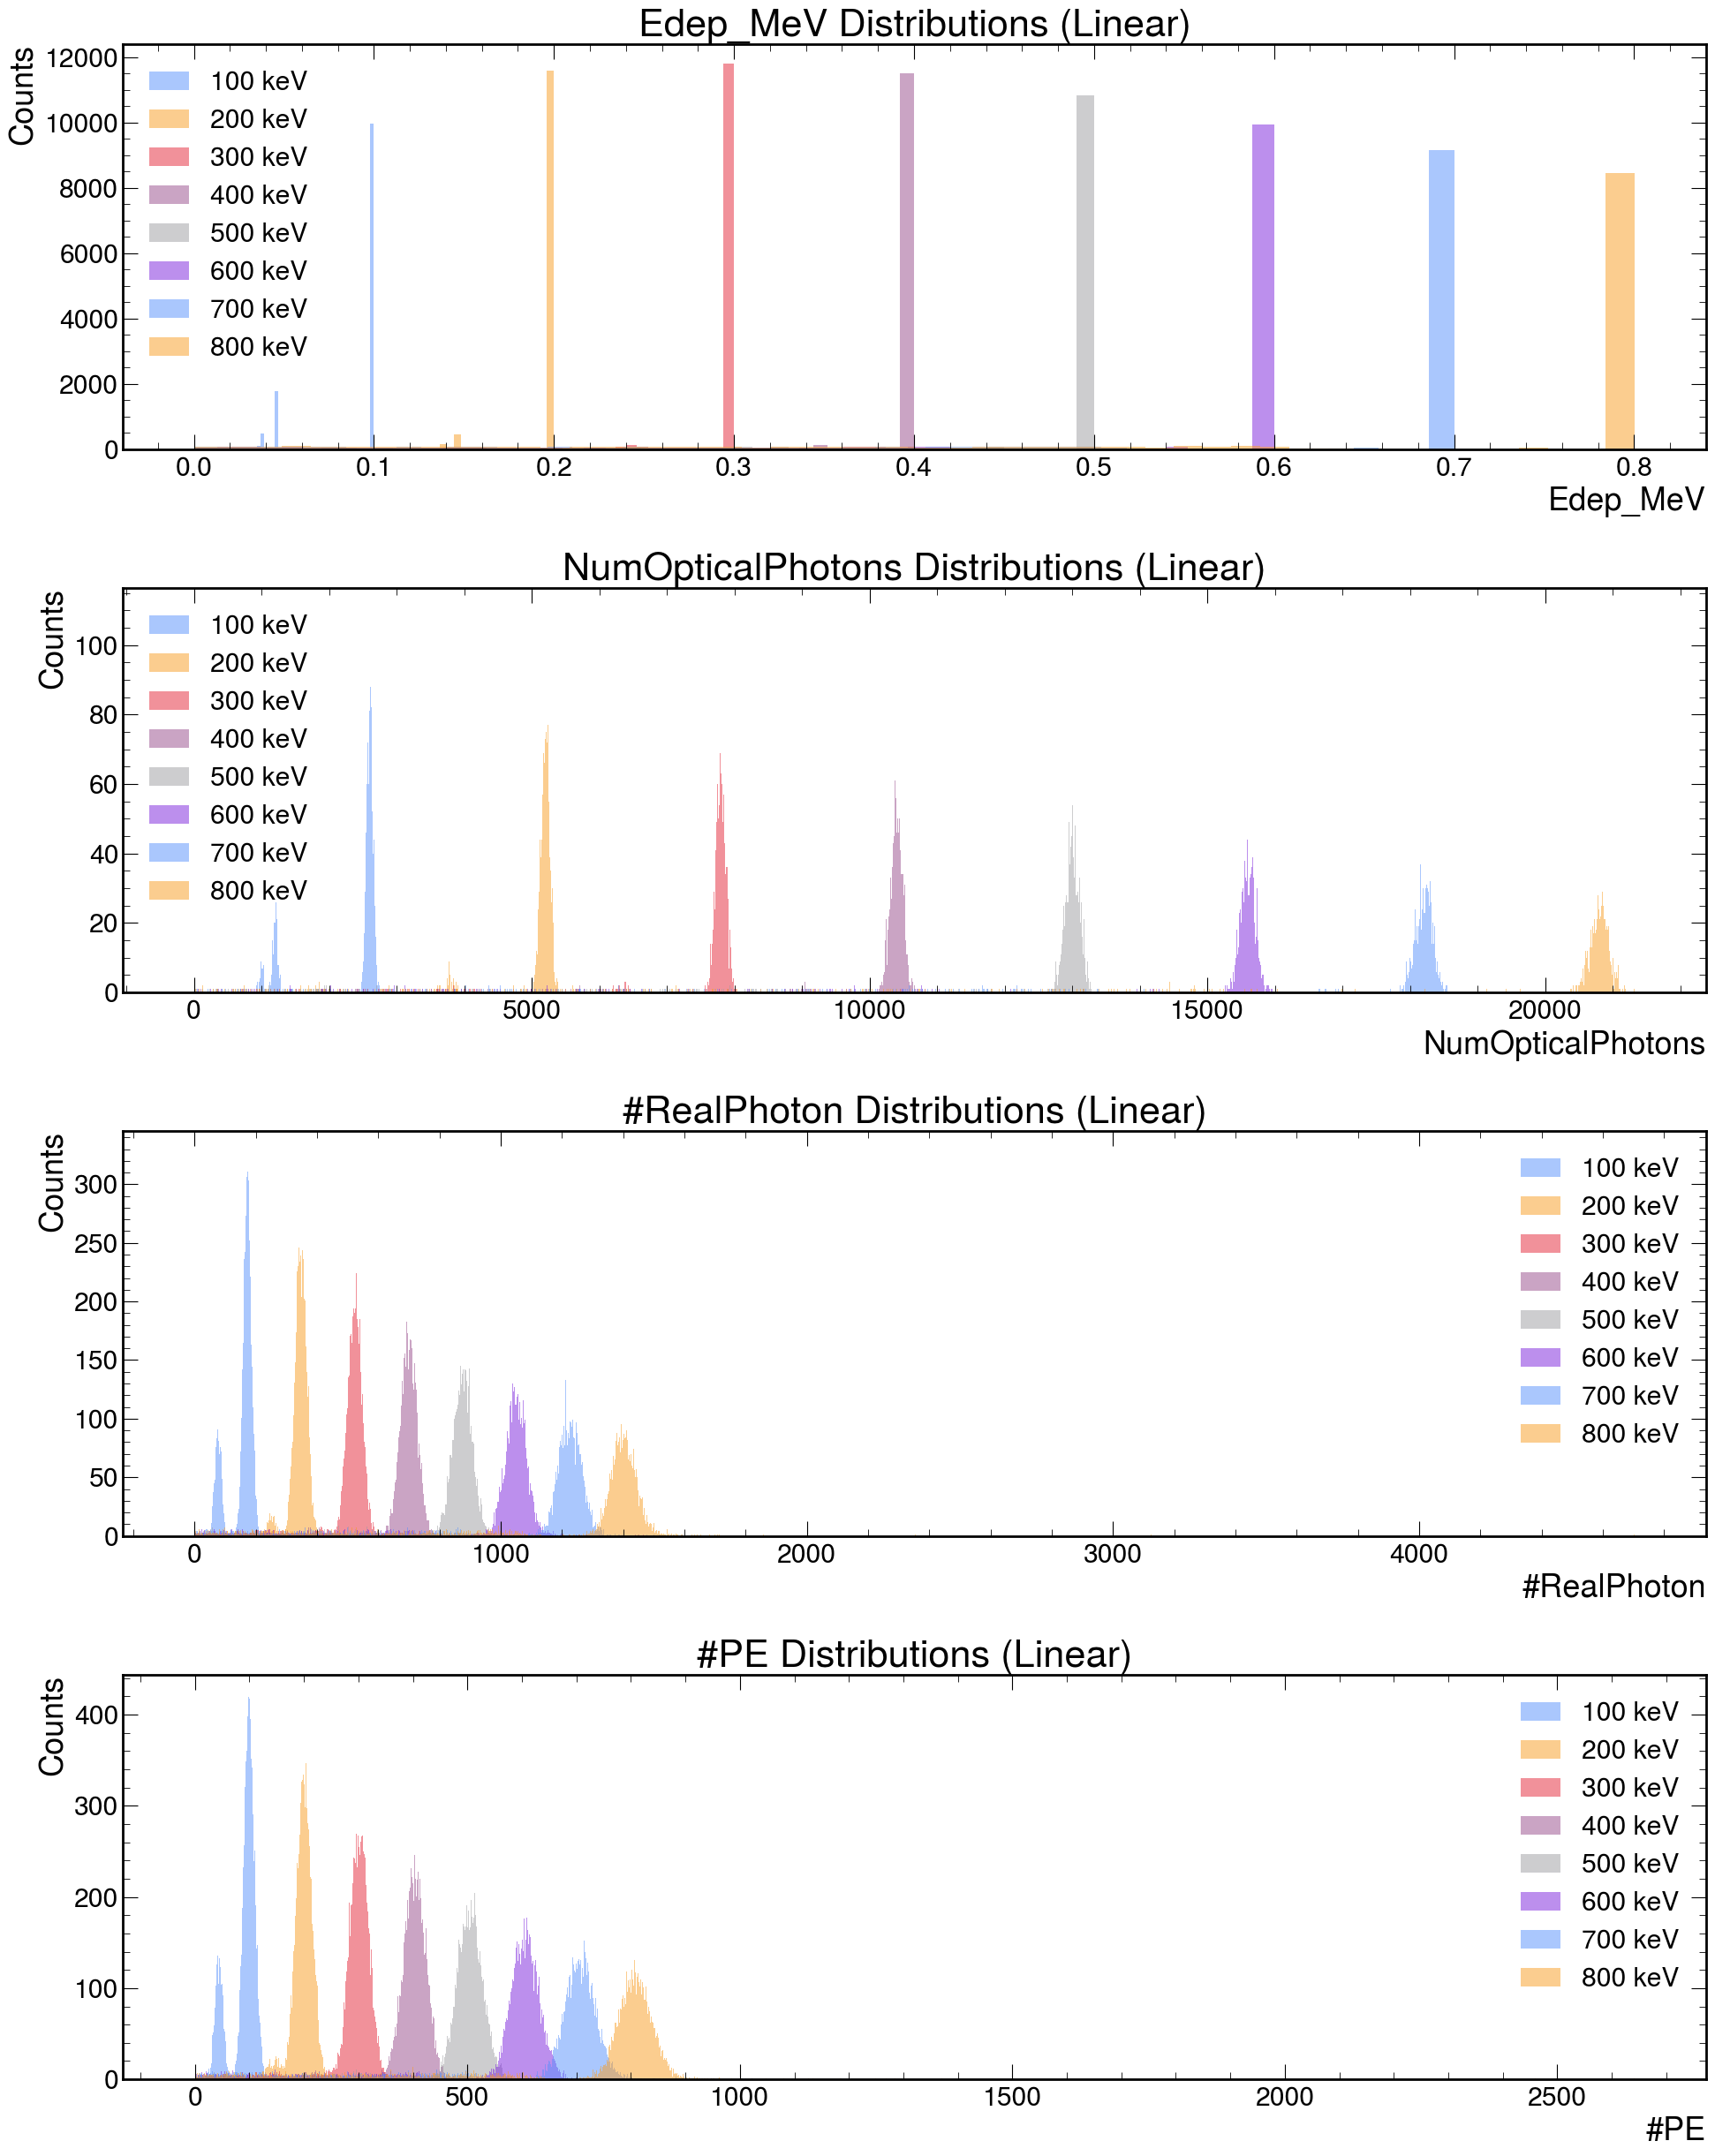

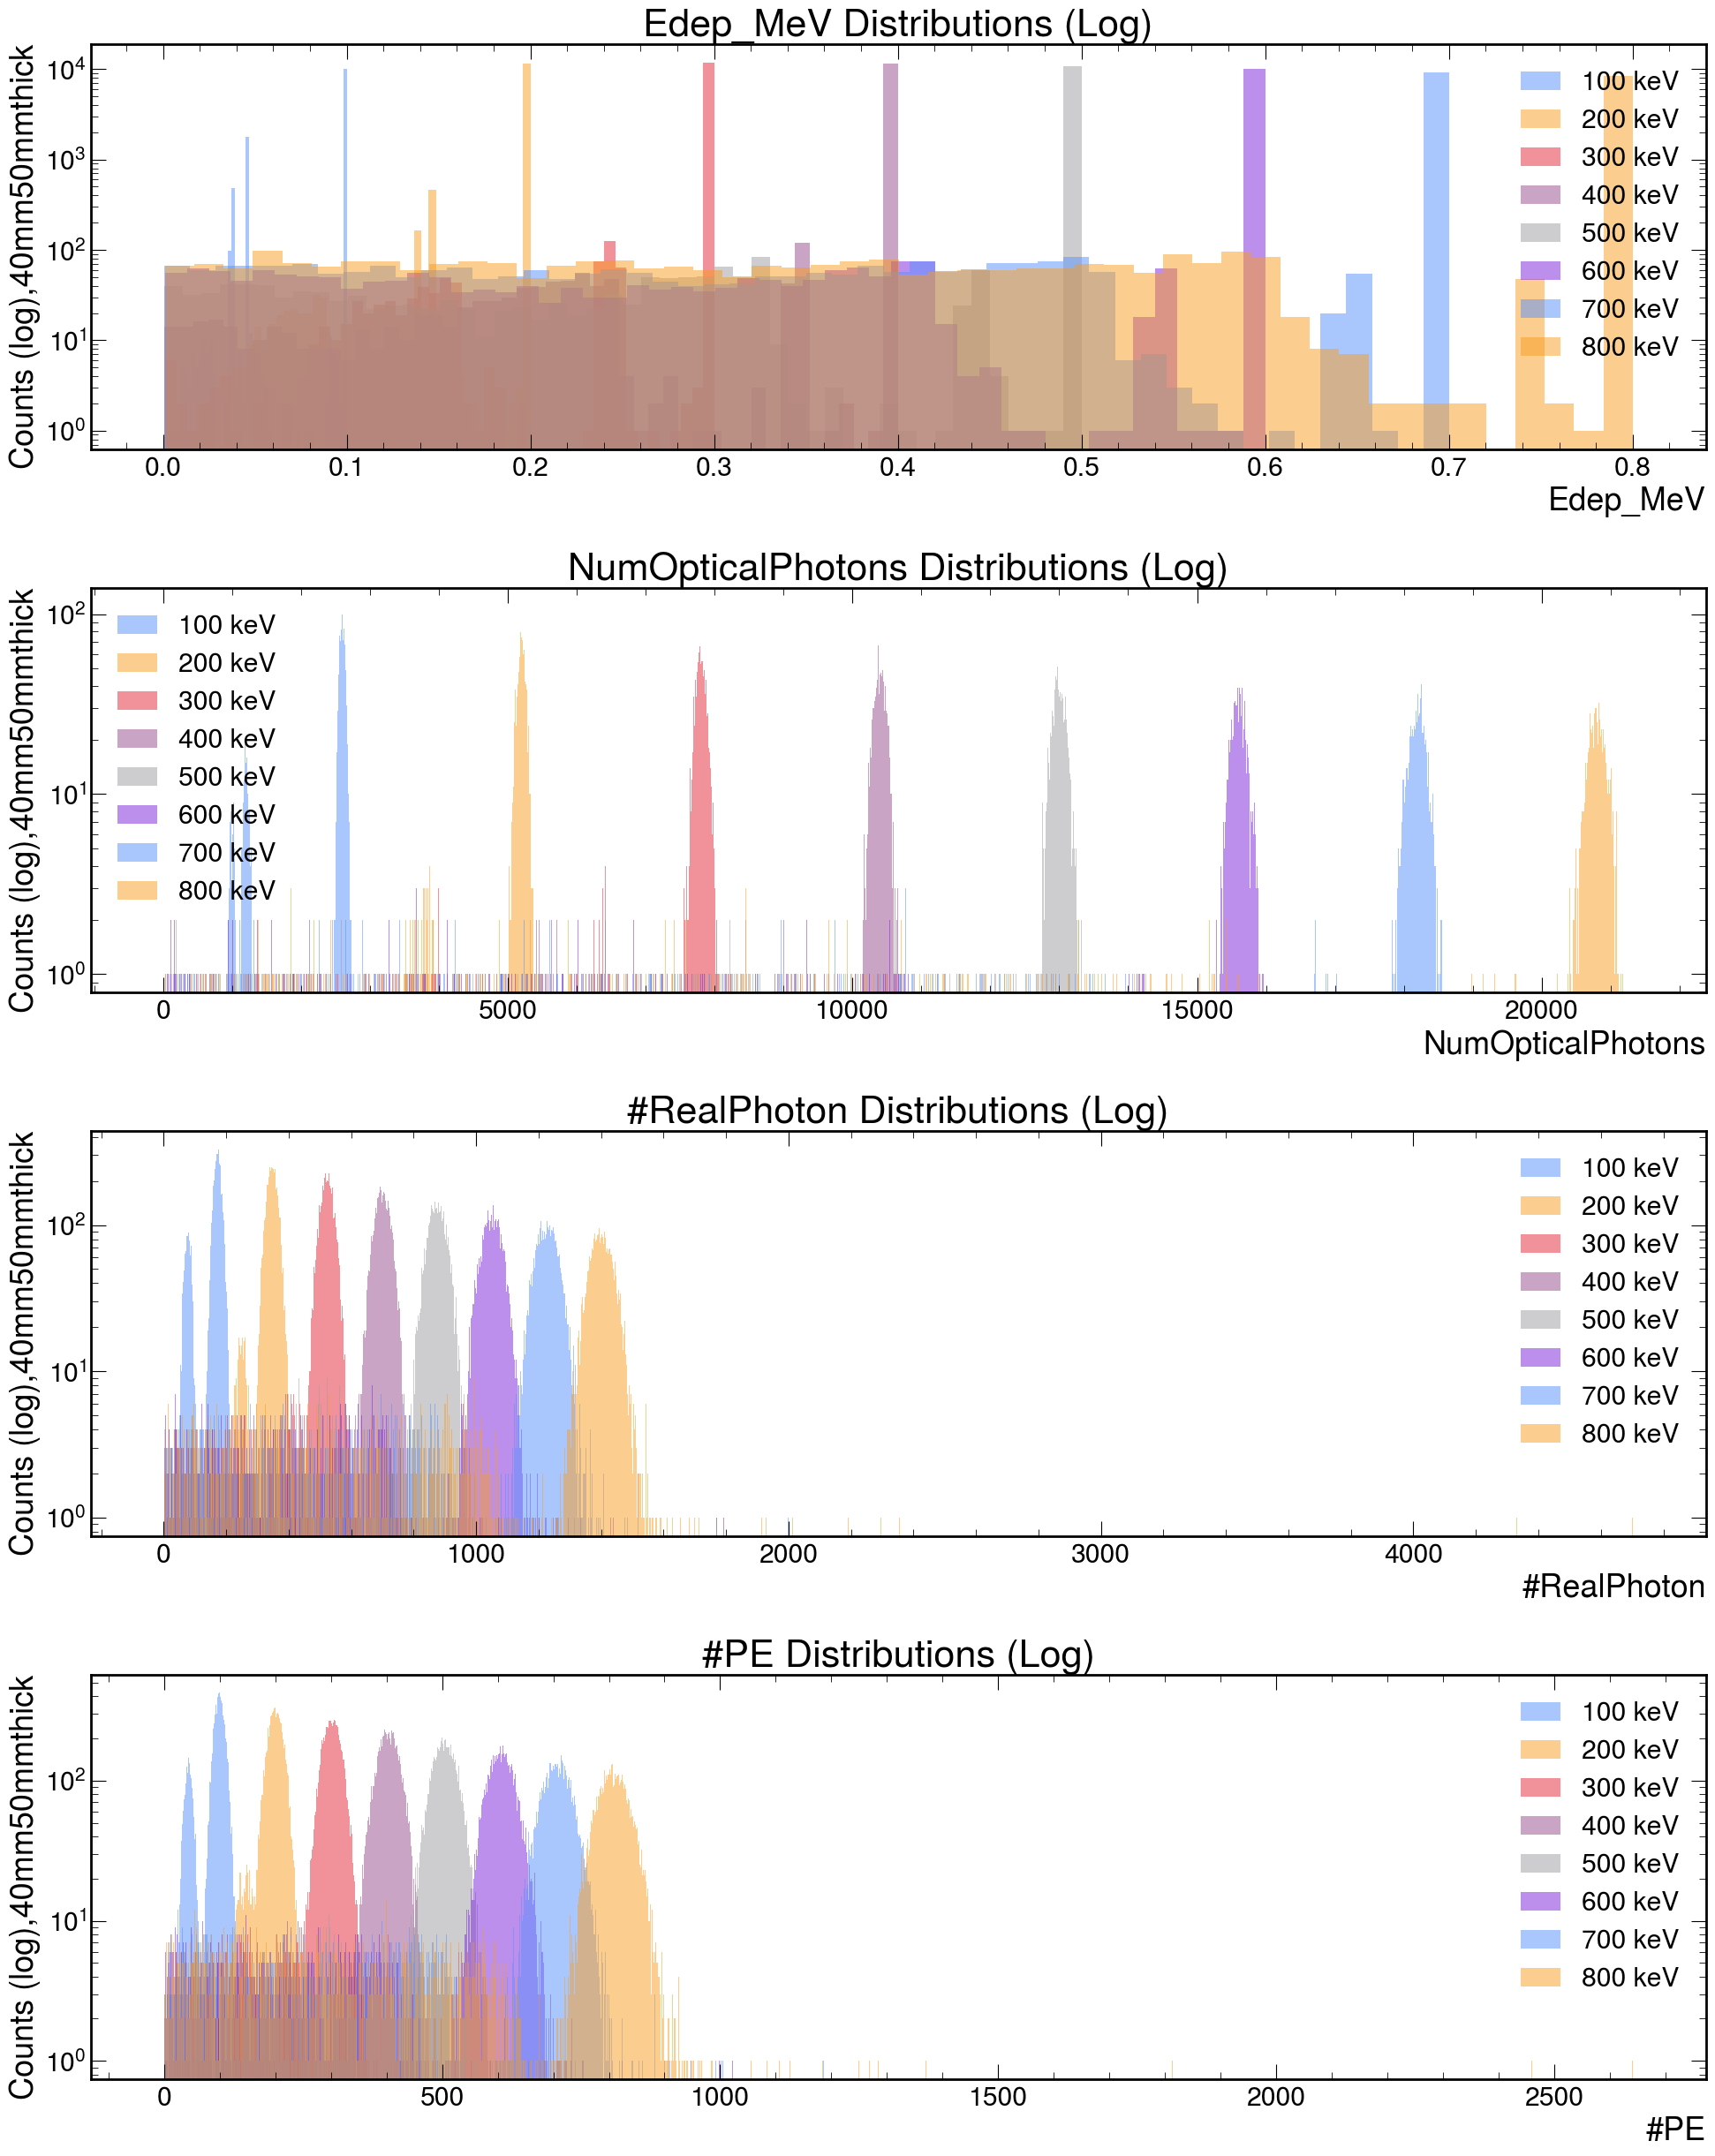

/tmp/ipykernel_114814/13027582.py:108: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.tight_layout()
/tmp/ipykernel_114814/13027582.py:109: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_lin.savefig(dir_name + '/histograms_linear.png')
/tmp/ipykernel_114814/13027582.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.tight_layout()
/tmp/ipykernel_114814/13027582.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig_log.savefig(dir_name + '/histograms_log.png')
/home/eltisau/software/miniconda3/envs/MG5/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


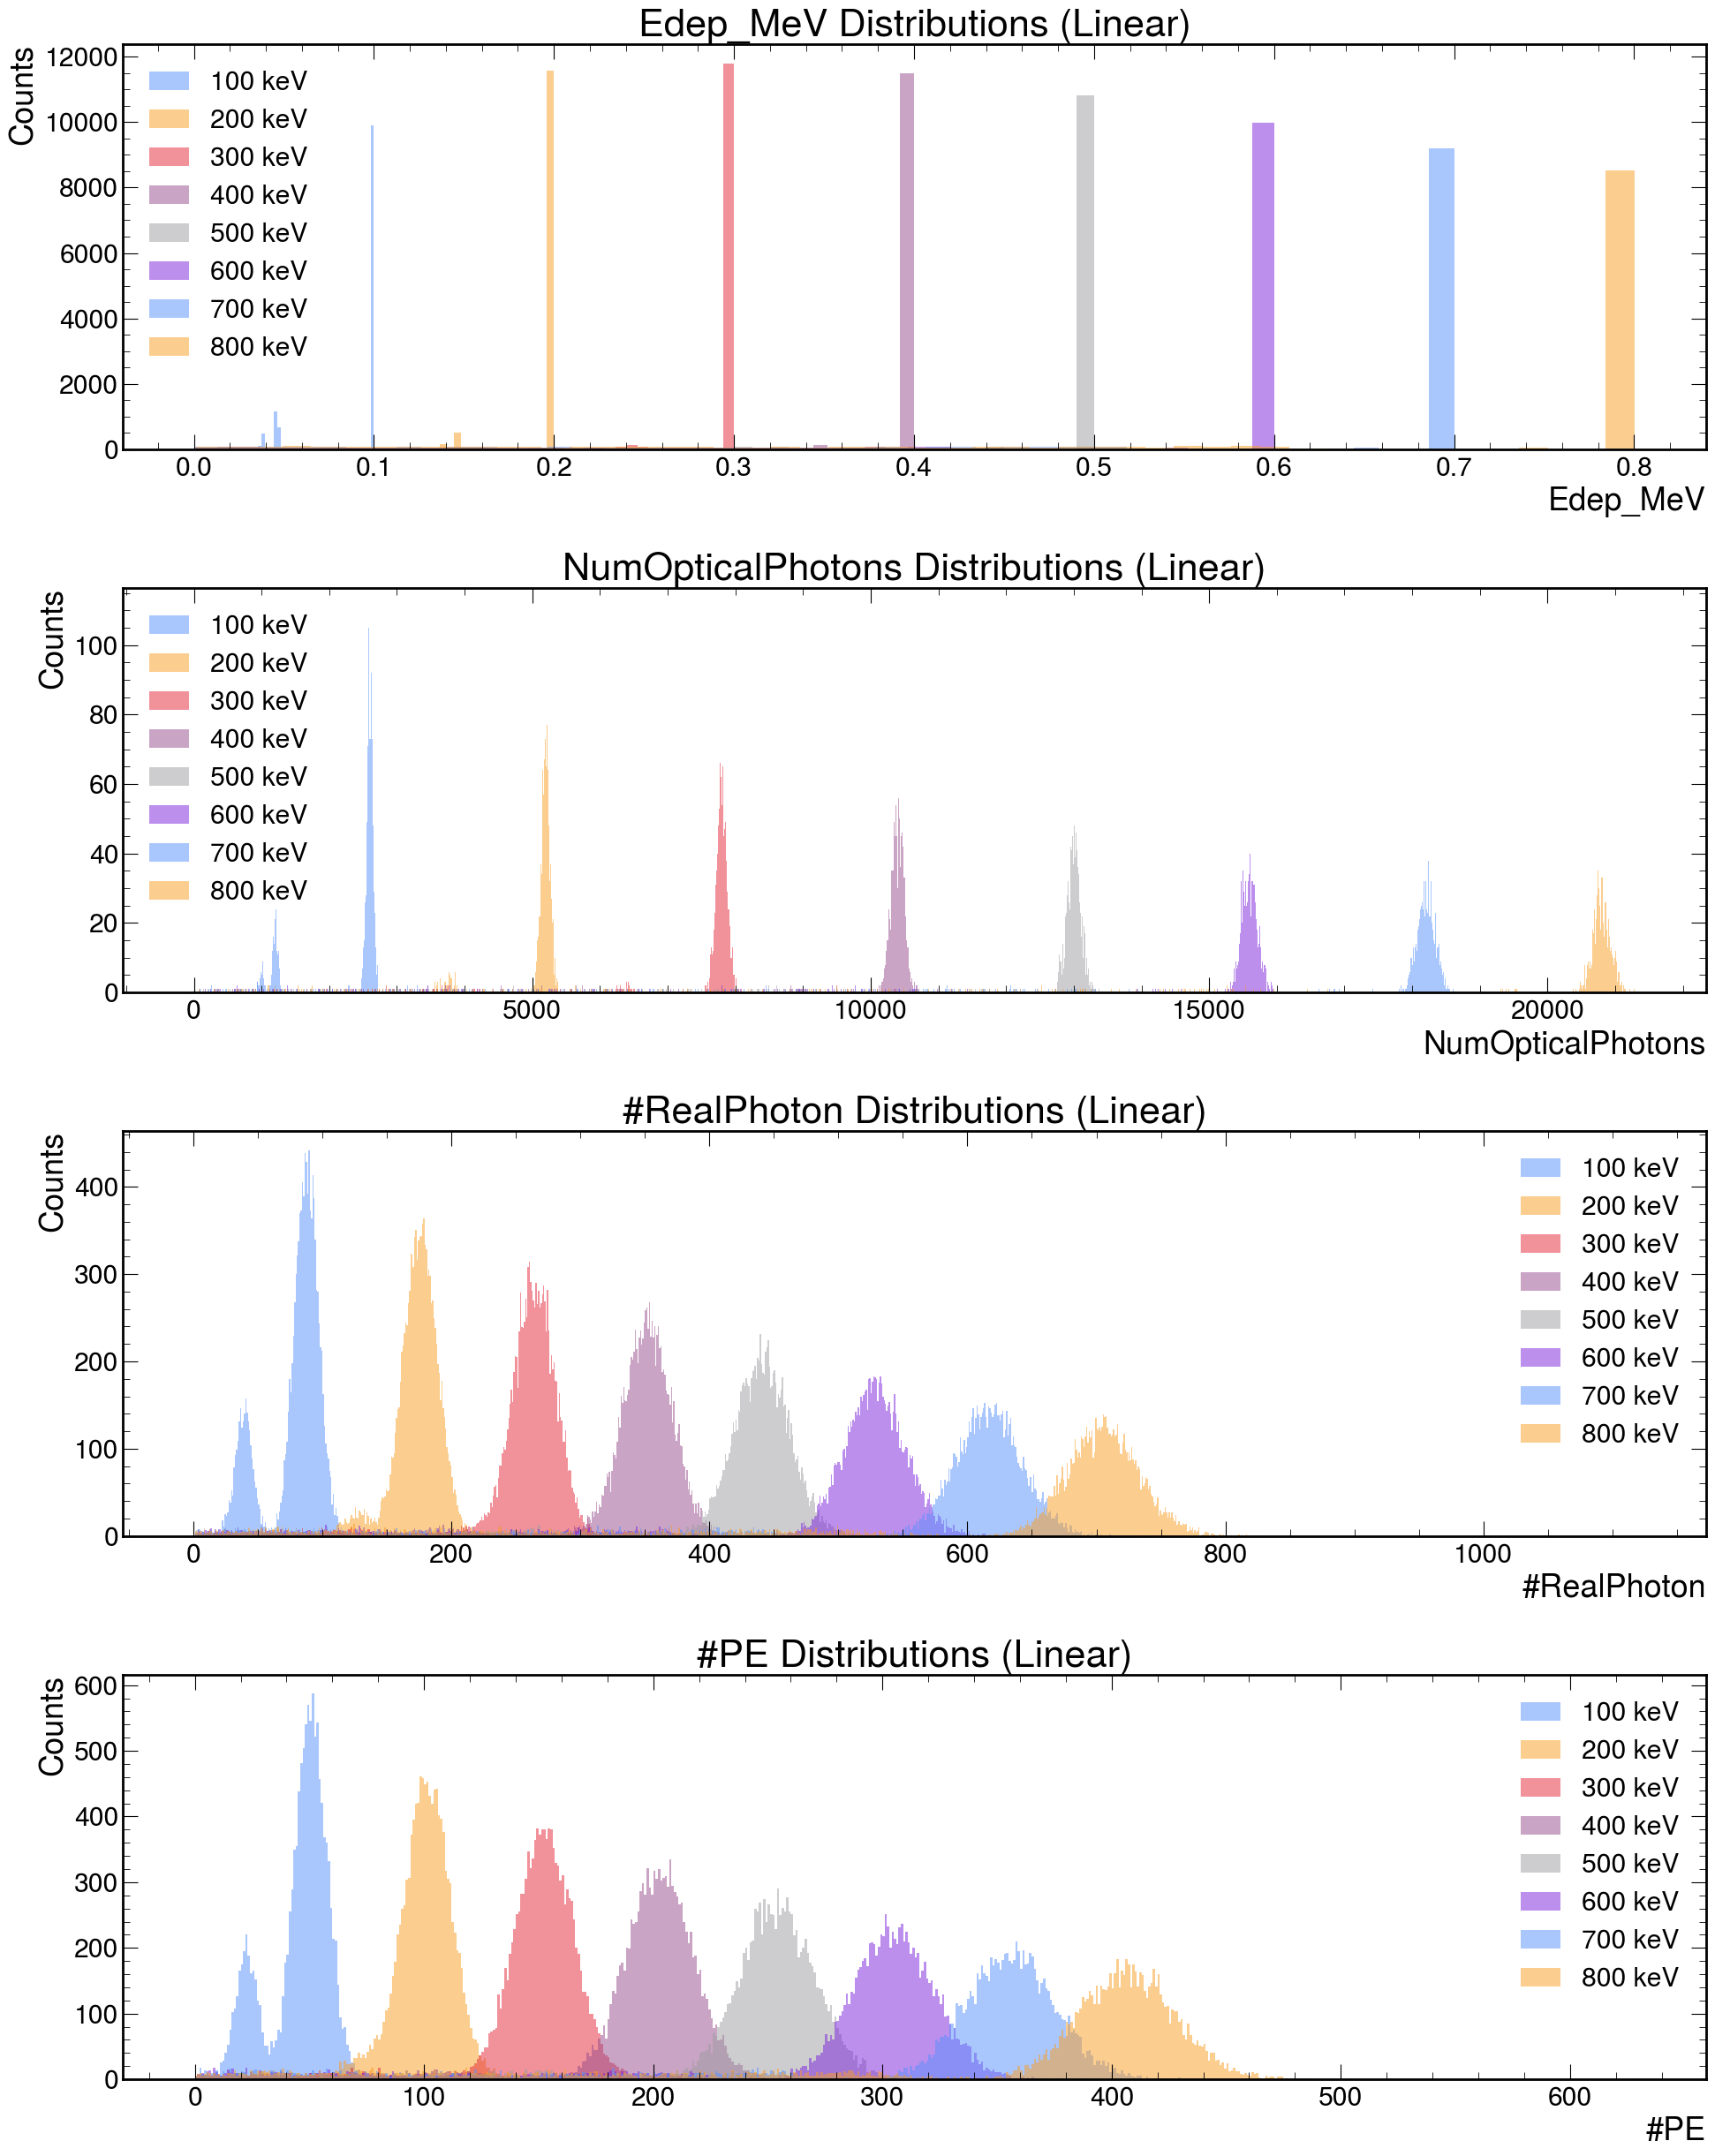

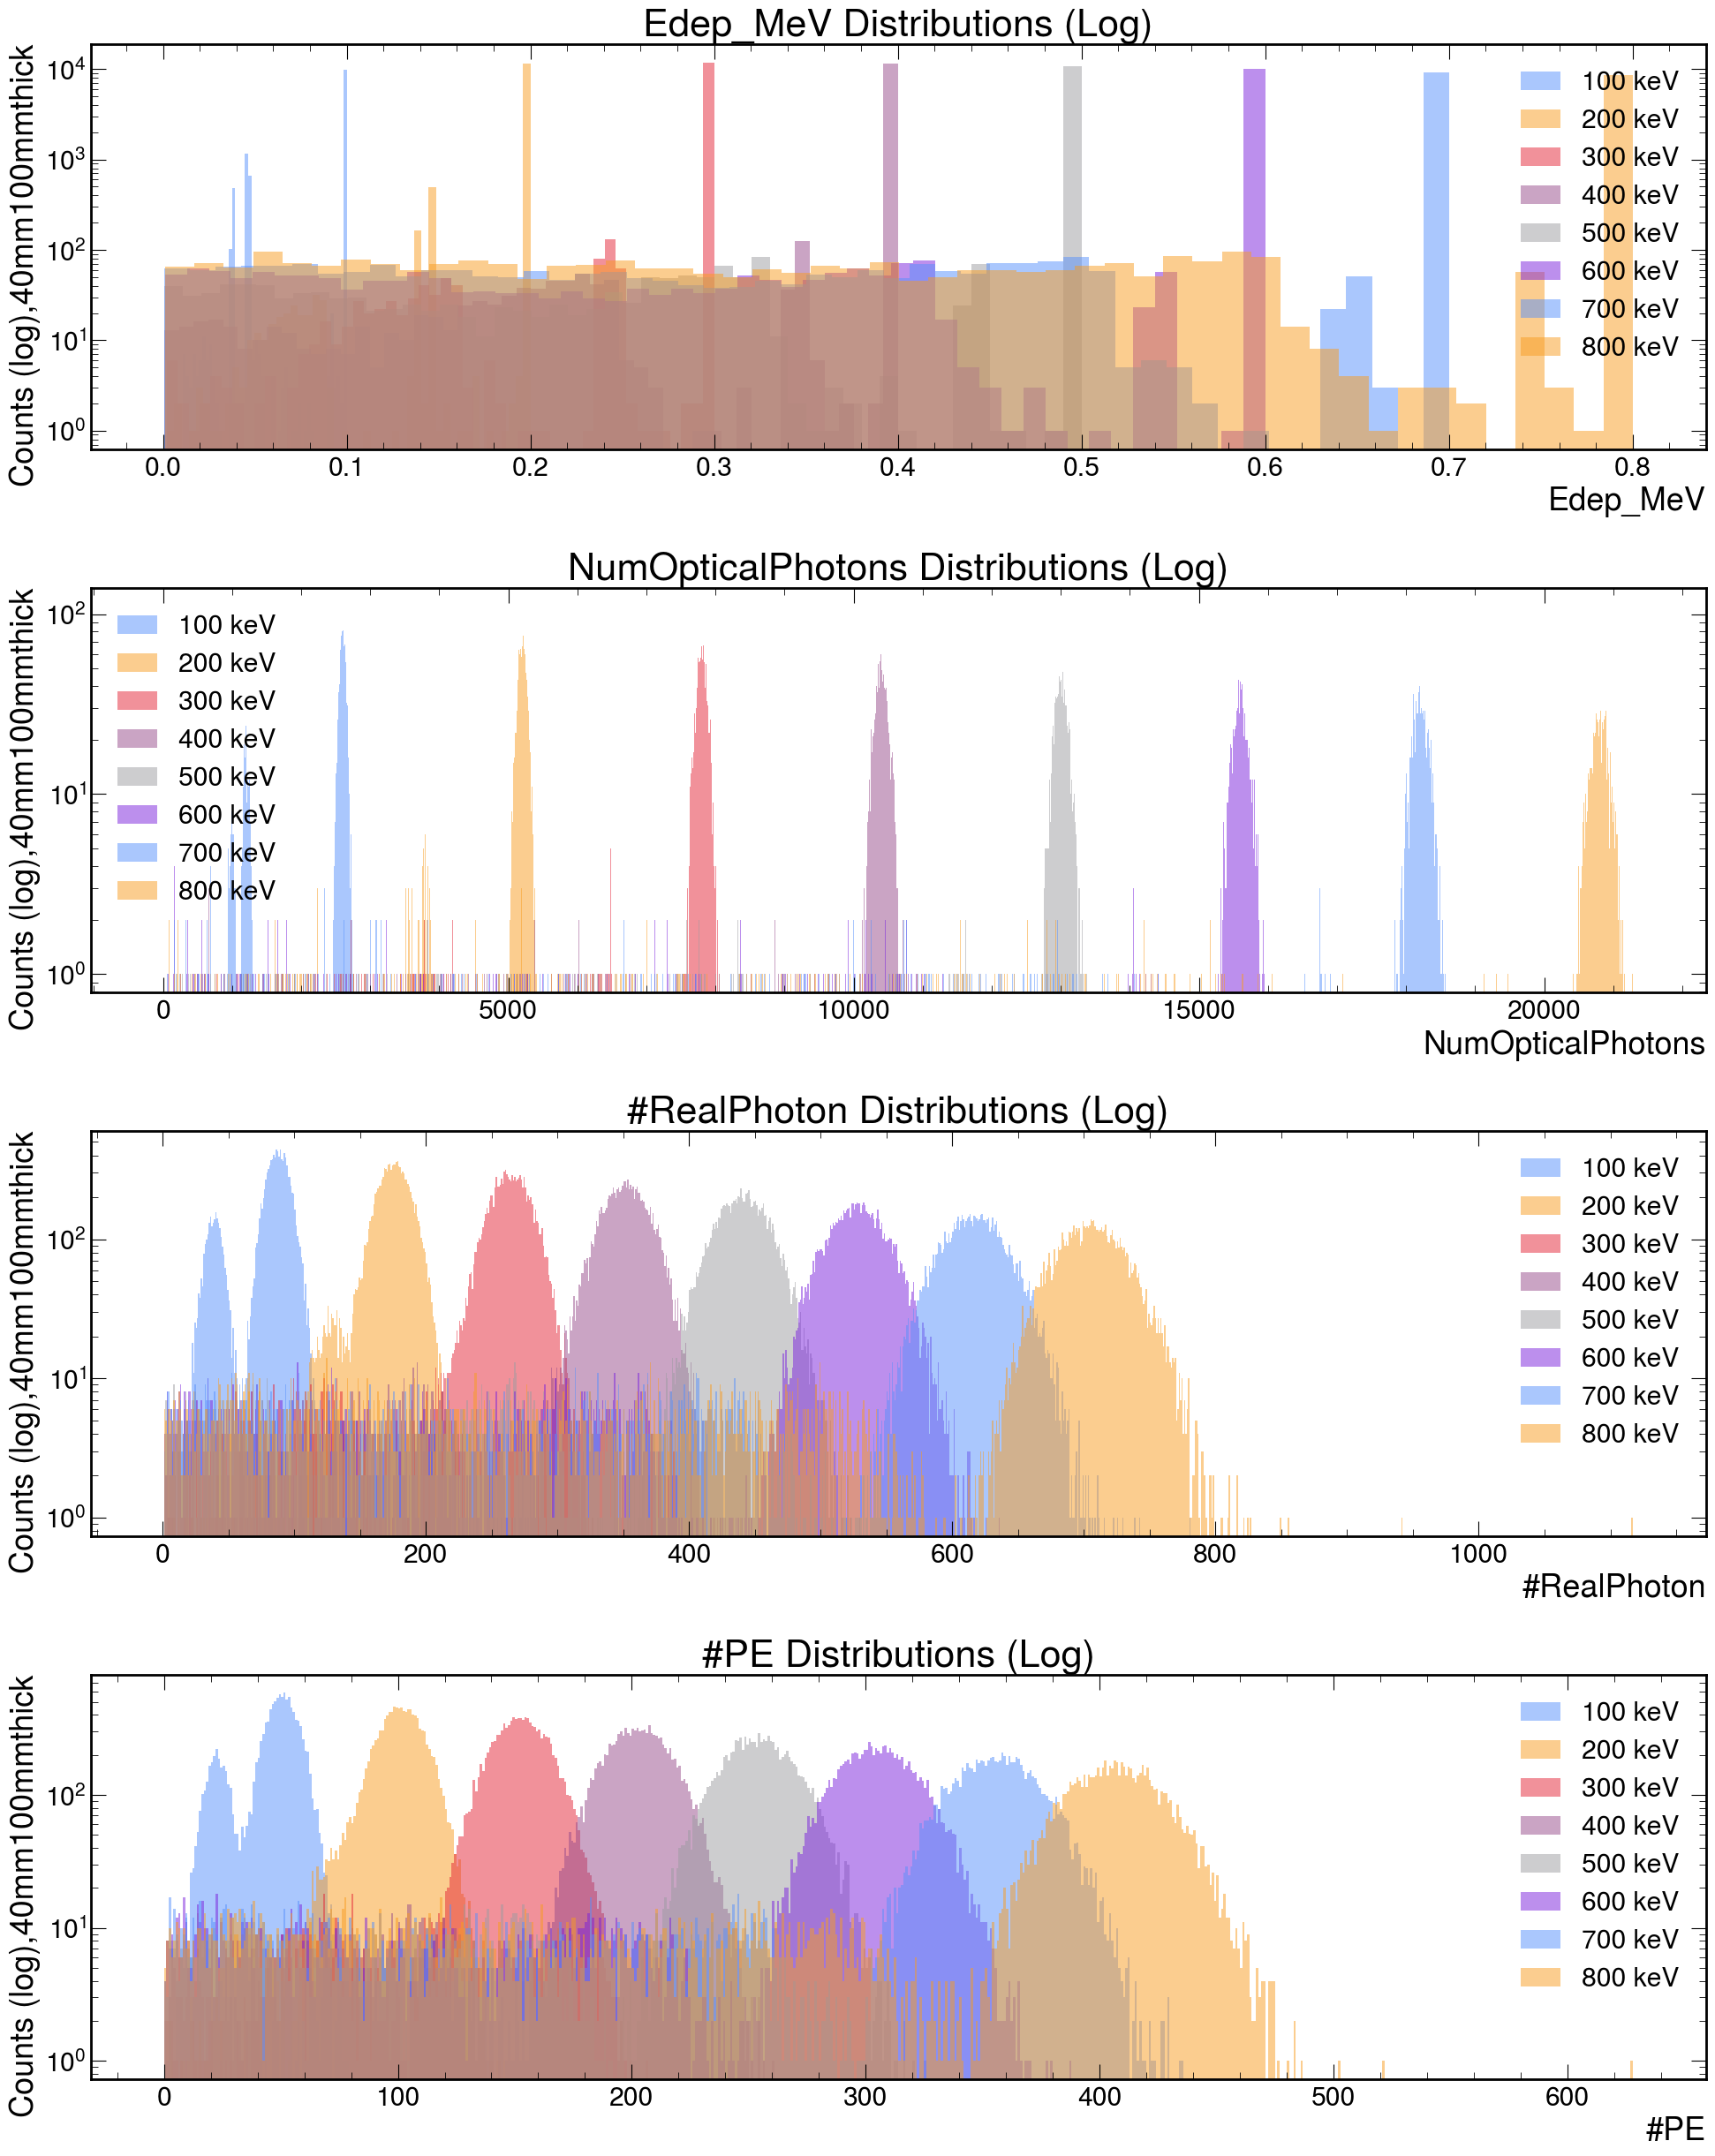

In [56]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_fwhm_and_peak(values):
    if len(values) == 0:
        return np.nan, np.nan
    min_val = int(values.min())
    max_val = int(values.max())
    bins = np.arange(min_val, max_val + 2)
    hist, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    if hist.max() == 0:
        return np.nan, np.nan
    peak_idx = np.argmax(hist)
    peak = bin_centers[peak_idx]
    half_max = hist.max() / 2.0
    # Find left crossing
    left_cross = bin_centers[0]
    for i in range(peak_idx, 0, -1):
        if hist[i] >= half_max > hist[i-1]:
            frac = (half_max - hist[i-1]) / (hist[i] - hist[i-1])
            left_cross = bin_centers[i-1] + frac * (bin_centers[i] - bin_centers[i-1])
            break
    # Find right crossing
    right_cross = bin_centers[-1]
    for i in range(peak_idx, len(hist) - 1):
        if hist[i] >= half_max > hist[i+1]:
            frac = (half_max - hist[i+1]) / (hist[i] - hist[i+1])
            right_cross = bin_centers[i+1] + frac * (bin_centers[i+1] - bin_centers[i])
            break
    fwhm = right_cross - left_cross
    return peak, fwhm

def compute_resolution_with_error(values, n_bootstrap=100):
    res_list = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, len(values), replace=True)
        peak, fwhm = compute_fwhm_and_peak(sample)
        if not np.isnan(peak) and peak != 0 and not np.isnan(fwhm):
            res_list.append(fwhm / peak)
    if not res_list:
        return np.nan, np.nan
    return np.mean(res_list), np.std(res_list)

def compute_efficiency_with_error(numerator, denominator, n_bootstrap=100):
    eff_list = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(numerator), len(numerator), replace=True)
        sample_num = numerator[indices]
        sample_den = denominator[indices]
        valid = sample_den > 0
        if np.sum(valid) > 0:
            eff_list.append(np.mean(sample_num[valid] / sample_den[valid]))
    if not eff_list:
        return np.nan, np.nan
    return np.mean(eff_list), np.std(eff_list)

folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]
for dir_name in folders:
    # Open the combined ROOT file
    with uproot.open(dir_name + '/combined.root') as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        # Read into DataFrames
        edep_df = edep_tree.arrays(library='pd')
        sipm_df = sipm_tree.arrays(library='pd')
    # Merge with EdepCounter (sipm_df is already per-event)
    merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])
    # Get unique energies
    energies = sorted(merged_df['Energy_keV'].unique())
    # Plot histograms on the same figure (overlaid for different energies)
    fig_lin, axes_lin = plt.subplots(4, 1, figsize=(20, 25))  # Linear version
    fig_log, axes_log = plt.subplots(4, 1, figsize=(20, 25))  # Log version
    for energy in energies:
        df_energy = merged_df[merged_df['Energy_keV'] == energy]
        label = f'{energy} keV'
        # Histogram for Edep_MeV (use auto bins since float)
        axes_lin[0].hist(df_energy['Edep_MeV'], bins=50, alpha=0.5, label=label)
        axes_log[0].hist(df_energy['Edep_MeV'], bins=50, alpha=0.5, label=label)
        # Histogram for NumOpticalPhotons (integer bins)
        min_op = int(df_energy['NumOpticalPhotons'].min())
        max_op = int(df_energy['NumOpticalPhotons'].max())
        axes_lin[1].hist(df_energy['NumOpticalPhotons'], bins=range(min_op, max_op + 2), alpha=0.5, label=label)
        axes_log[1].hist(df_energy['NumOpticalPhotons'], bins=range(min_op, max_op + 2), alpha=0.5, label=label)
        # Histogram for #RealPhoton (integer bins)
        min_rp = int(df_energy['#RealPhoton'].min())
        max_rp = int(df_energy['#RealPhoton'].max())
        axes_lin[2].hist(df_energy['#RealPhoton'], bins=range(min_rp, max_rp + 2), alpha=0.5, label=label)
        axes_log[2].hist(df_energy['#RealPhoton'], bins=range(min_rp, max_rp + 2), alpha=0.5, label=label)
        # Histogram for #PE (integer bins)
        min_pe = int(df_energy['#PE'].min())
        max_pe = int(df_energy['#PE'].max())
        axes_lin[3].hist(df_energy['#PE'], bins=range(min_pe, max_pe + 2), alpha=0.5, label=label)
        axes_log[3].hist(df_energy['#PE'], bins=range(min_pe, max_pe + 2), alpha=0.5, label=label)
    for ax_lin, ax_log, title_suffix in zip(axes_lin, axes_log, ['Edep_MeV', 'NumOpticalPhotons', '#RealPhoton', '#PE']):
        ax_lin.set_title(f'{title_suffix} Distributions (Linear)')
        ax_lin.set_xlabel(title_suffix)
        ax_lin.set_ylabel('Counts')
        ax_lin.legend()
        ax_log.set_yscale('log')
        ax_log.set_title(f'{title_suffix} Distributions (Log)')
        ax_log.set_xlabel(title_suffix)
        ax_log.set_ylabel('Counts (log),'+dir_name)
        ax_log.legend()
    fig_lin.tight_layout()
    fig_lin.savefig(dir_name + '/histograms_linear.png')
    fig_log.tight_layout()
    fig_log.savefig(dir_name + '/histograms_log.png')
    plt.show()

# Energy Resolution

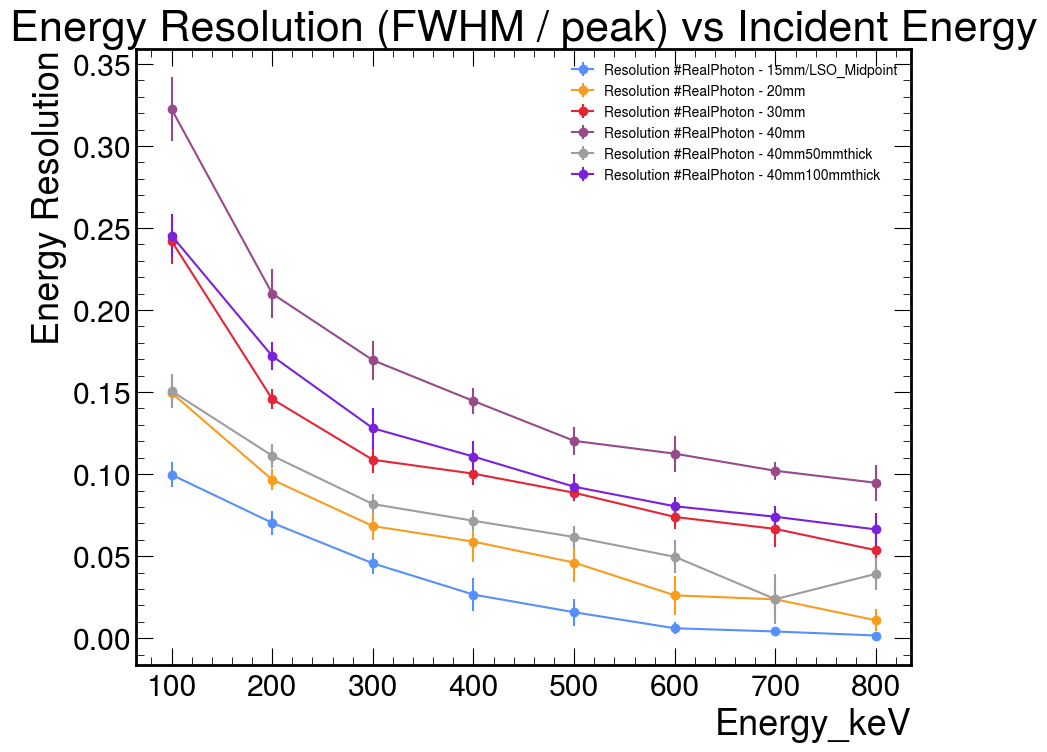

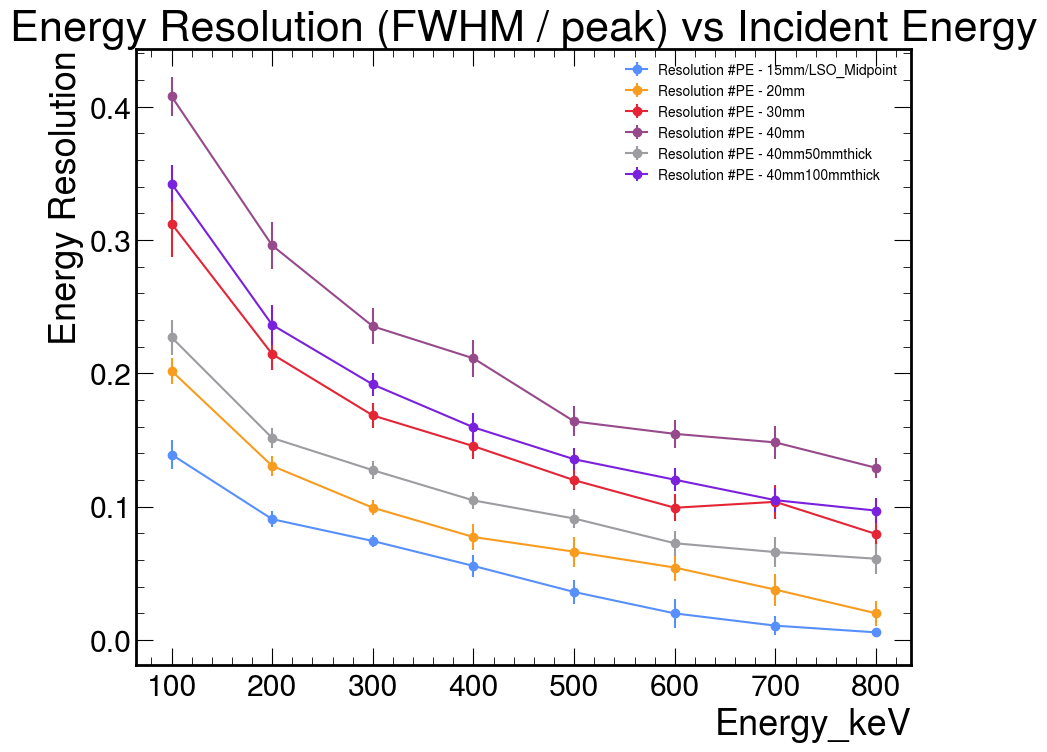

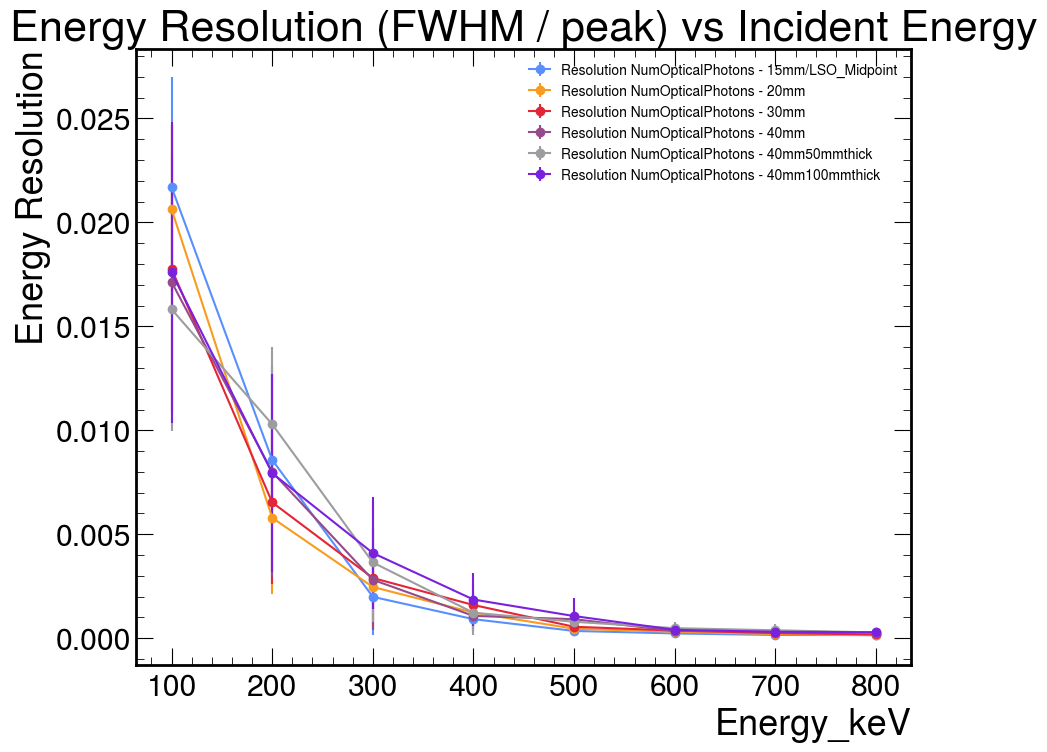

In [52]:
folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]

# Collect resolution data from all folders
all_res_real = {}
all_res_pe = {}
all_res_op = {}
all_err_real = {}
all_err_pe = {}
all_err_op = {}
energies_set = set()

for dir_name in folders:
    # Open the combined ROOT file
    with uproot.open(dir_name + '/combined.root') as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        # Read into DataFrames
        edep_df = edep_tree.arrays(library='pd')
        sipm_df = sipm_tree.arrays(library='pd')
    # Merge with EdepCounter (sipm_df is already per-event)
    merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])
    # Get unique energies
    energies = sorted(merged_df['Energy_keV'].unique())
    energies_set.update(energies)
    # Compute resolutions
    res_real = []
    res_pe = []
    res_op = []
    err_real = []
    err_pe = []
    err_op = []
    for energy in energies:
        df_energy = merged_df[merged_df['Energy_keV'] == energy]
        res_rp, err_rp = compute_resolution_with_error(df_energy['#RealPhoton'].values)
        res_pe_val, err_pe_val = compute_resolution_with_error(df_energy['#PE'].values)
        res_op_val, err_op_val = compute_resolution_with_error(df_energy['NumOpticalPhotons'].values)
        res_real.append(res_rp)
        res_pe.append(res_pe_val)
        res_op.append(res_op_val)
        err_real.append(err_rp)
        err_pe.append(err_pe_val)
        err_op.append(err_op_val)
    all_res_real[dir_name] = res_real
    all_res_pe[dir_name] = res_pe
    all_res_op[dir_name] = res_op
    all_err_real[dir_name] = err_real
    all_err_pe[dir_name] = err_pe
    all_err_op[dir_name] = err_op

# Common energies for plotting
common_energies = sorted(list(energies_set))

# Plot all resolutions in one figure for #RealPhoton
fig_real, ax_real = plt.subplots(figsize=(10, 8))
for dir_name in folders:
    ax_real.errorbar(common_energies, all_res_real[dir_name], yerr=all_err_real[dir_name], fmt='o-', label=f'Resolution #RealPhoton - {dir_name}')
ax_real.set_xlabel('Energy_keV')
ax_real.set_ylabel('Energy Resolution')
ax_real.set_title('Energy Resolution (FWHM / peak) vs Incident Energy')
ax_real.legend(fontsize=10)
plt.show()

# Plot all resolutions in one figure for #PE
fig_pe, ax_pe = plt.subplots(figsize=(10, 8))
for dir_name in folders:
    ax_pe.errorbar(common_energies, all_res_pe[dir_name], yerr=all_err_pe[dir_name], fmt='o-', label=f'Resolution #PE - {dir_name}')
ax_pe.set_xlabel('Energy_keV')
ax_pe.set_ylabel('Energy Resolution')
ax_pe.set_title('Energy Resolution (FWHM / peak) vs Incident Energy')
ax_pe.legend(fontsize=10)
plt.show()

# Plot all resolutions in one figure for NumOpticalPhotons
fig_op, ax_op = plt.subplots(figsize=(10, 8))
for dir_name in folders:
    ax_op.errorbar(common_energies, all_res_op[dir_name], yerr=all_err_op[dir_name], fmt='o-', label=f'Resolution NumOpticalPhotons - {dir_name}')
ax_op.set_xlabel('Energy_keV')
ax_op.set_ylabel('Energy Resolution')
ax_op.set_title('Energy Resolution (FWHM / peak) vs Incident Energy')
ax_op.legend(fontsize=10)
plt.show()

# Detection Efficiecny

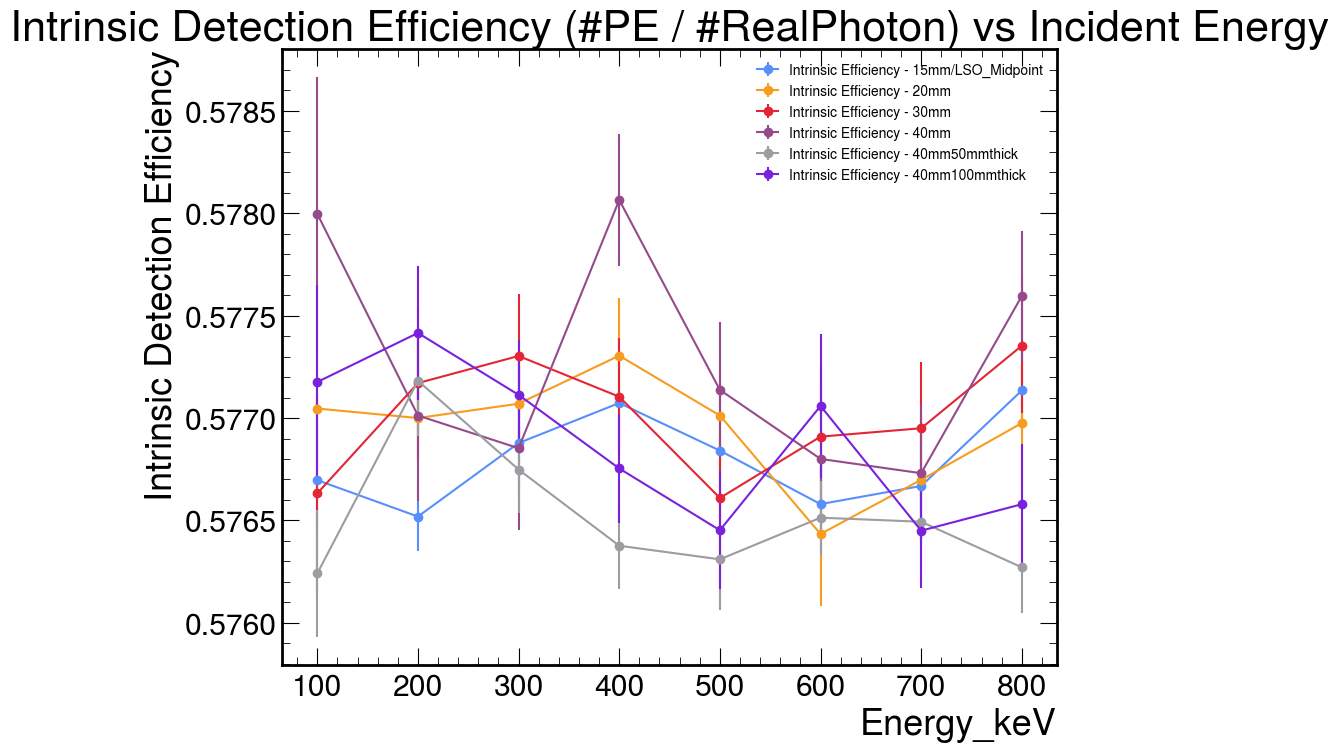

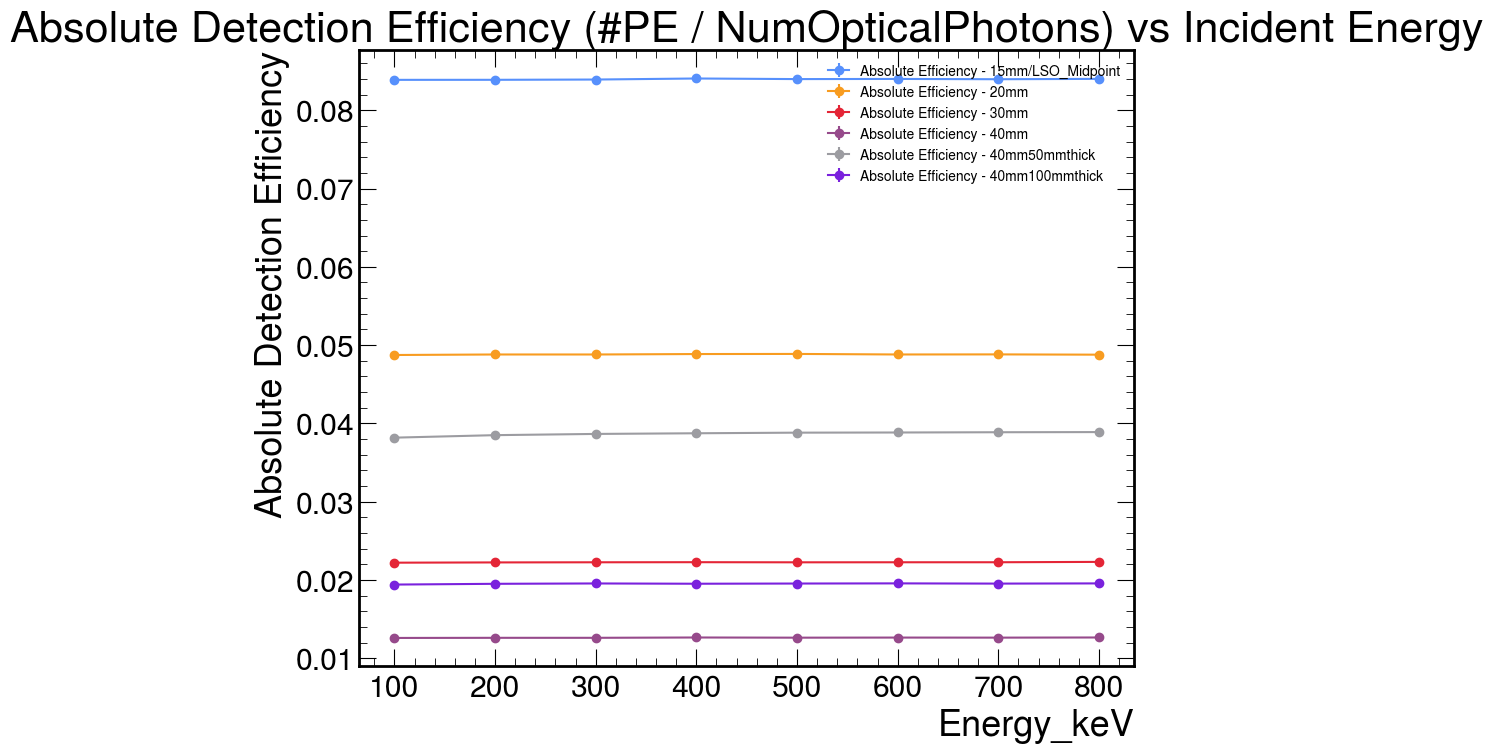

In [55]:
folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]

# Collect efficiency data from all folders
all_eff_intrinsic = {}
all_eff_absolute = {}
all_err_intrinsic = {}
all_err_absolute = {}
energies_set = set()

for dir_name in folders:
    # Open the combined ROOT file
    with uproot.open(dir_name + '/combined.root') as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        # Read into DataFrames
        edep_df = edep_tree.arrays(library='pd')
        sipm_df = sipm_tree.arrays(library='pd')
    # Merge with EdepCounter (sipm_df is already per-event)
    merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])
    # Get unique energies
    energies = sorted(merged_df['Energy_keV'].unique())
    energies_set.update(energies)
    # Compute efficiencies
    eff_intrinsic = []
    eff_absolute = []
    err_intrinsic = []
    err_absolute = []
    for energy in energies:
        df_energy = merged_df[merged_df['Energy_keV'] == energy]
        # Intrinsic (PDE: #PE / #RealPhoton)
        eff_int, err_int = compute_efficiency_with_error(df_energy['#PE'].values, df_energy['#RealPhoton'].values)
        # Absolute (#PE / NumOpticalPhotons)
        eff_abs, err_abs = compute_efficiency_with_error(df_energy['#PE'].values, df_energy['NumOpticalPhotons'].values)
        eff_intrinsic.append(eff_int)
        eff_absolute.append(eff_abs)
        err_intrinsic.append(err_int)
        err_absolute.append(err_abs)
    all_eff_intrinsic[dir_name] = eff_intrinsic
    all_eff_absolute[dir_name] = eff_absolute
    all_err_intrinsic[dir_name] = err_intrinsic
    all_err_absolute[dir_name] = err_absolute

# Common energies for plotting
common_energies = sorted(list(energies_set))

# Plot all intrinsic efficiencies in one figure
fig_intrinsic, ax_intrinsic = plt.subplots(figsize=(10, 8))
for dir_name in folders:
    ax_intrinsic.errorbar(common_energies, all_eff_intrinsic[dir_name], yerr=all_err_intrinsic[dir_name], fmt='o-', label=f'Intrinsic Efficiency - {dir_name}')
ax_intrinsic.set_xlabel('Energy_keV')
ax_intrinsic.set_ylabel('Intrinsic Detection Efficiency')
ax_intrinsic.set_title('Intrinsic Detection Efficiency (#PE / #RealPhoton) vs Incident Energy')
ax_intrinsic.legend(fontsize=10)
plt.show()

# Plot all absolute efficiencies in one figure
fig_absolute, ax_absolute = plt.subplots(figsize=(10, 8))
for dir_name in folders:
    ax_absolute.errorbar(common_energies, all_eff_absolute[dir_name], yerr=all_err_absolute[dir_name], fmt='o-', label=f'Absolute Efficiency - {dir_name}')
ax_absolute.set_xlabel('Energy_keV')
ax_absolute.set_ylabel('Absolute Detection Efficiency')
ax_absolute.set_title('Absolute Detection Efficiency (#PE / NumOpticalPhotons) vs Incident Energy')
ax_absolute.legend(fontsize=10)
plt.show()

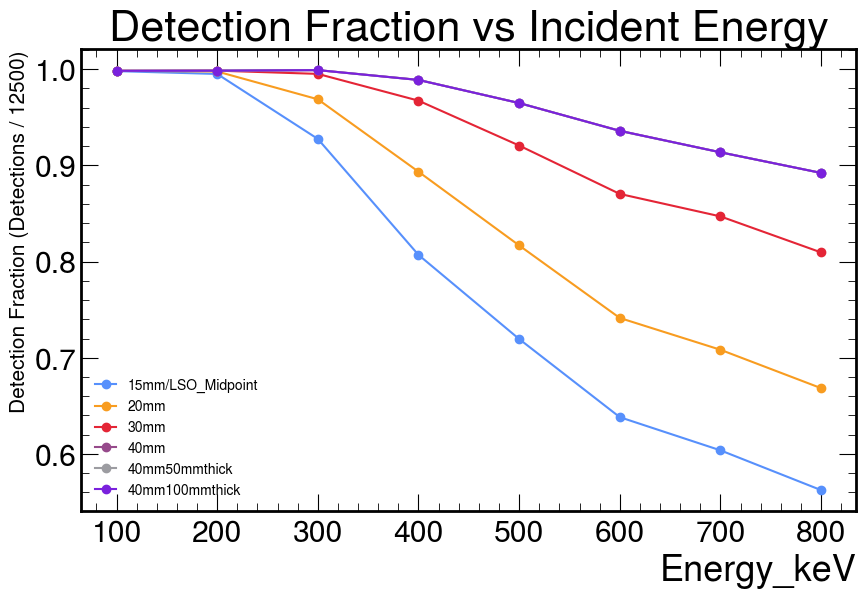

In [63]:
folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]
total_shots = 12500

# Collect detection fractions
all_fractions = {}
energies_set = set()

for dir_name in folders:
    with uproot.open(dir_name + '/combined.root') as root_file:
        edep_tree = root_file['EdepCounter']
        edep_df = edep_tree.arrays(library='pd')
    energies = sorted(edep_df['Energy_keV'].unique())
    energies_set.update(energies)
    fractions = []
    for energy in energies:
        num_detections = len(edep_df[edep_df['Energy_keV'] == energy])
        fraction = num_detections / total_shots
        fractions.append(fraction)
    all_fractions[dir_name] = fractions

common_energies = sorted(list(energies_set))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    ax.plot(common_energies, all_fractions[dir_name], 'o-', label=dir_name)
ax.set_xlabel('Energy_keV')
ax.set_ylabel('Detection Fraction (Detections / 12500)',fontsize=15)
ax.set_title('Detection Fraction vs Incident Energy')
ax.legend(fontsize=10)
plt.show()

# Peak to total

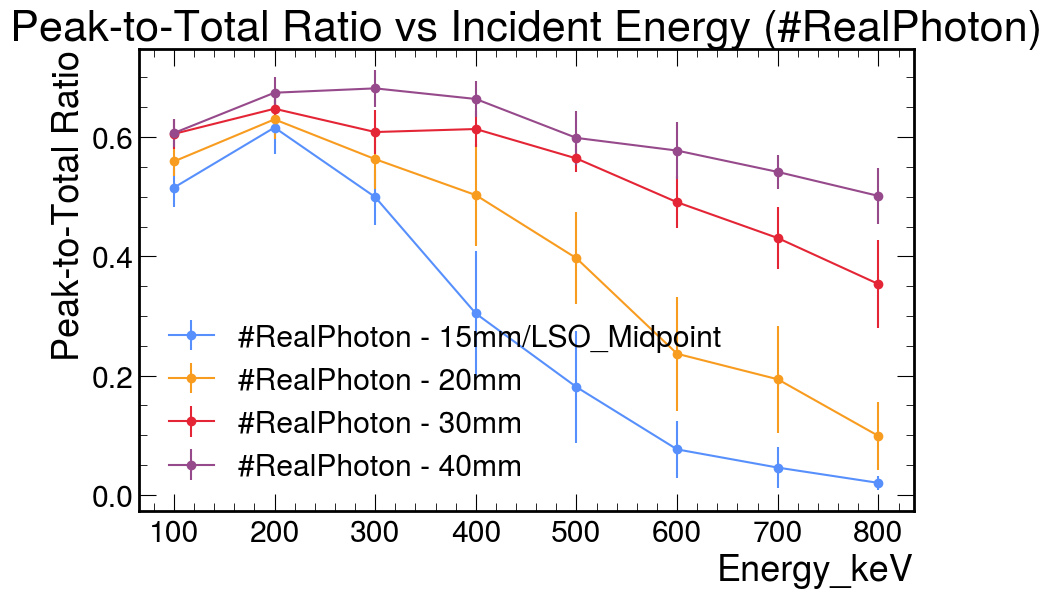

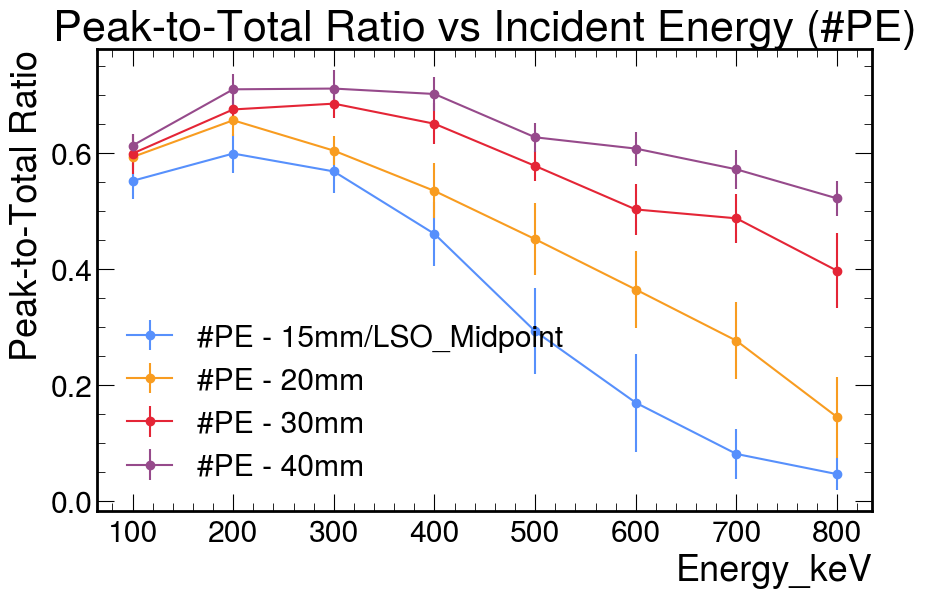

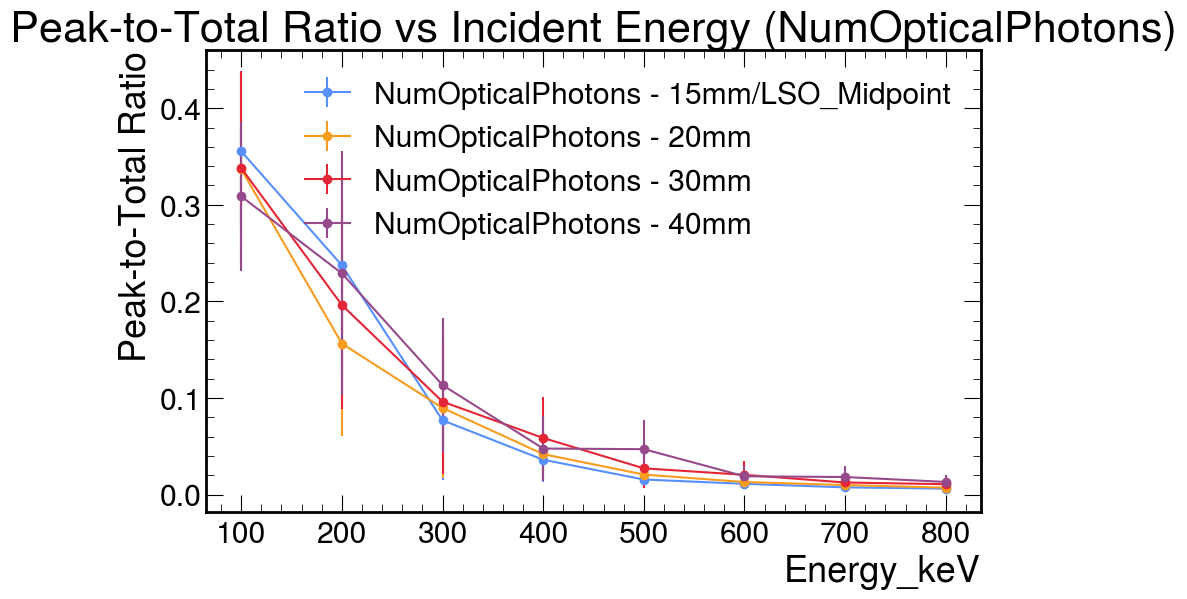

In [64]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_fwhm_and_peak(values):
    if len(values) == 0:
        return np.nan, np.nan
    min_val = int(values.min())
    max_val = int(values.max())
    bins = np.arange(min_val, max_val + 2)
    hist, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    if hist.max() == 0:
        return np.nan, np.nan
    peak_idx = np.argmax(hist)
    peak = bin_centers[peak_idx]
    half_max = hist.max() / 2.0
    # Find left crossing
    left_cross = bin_centers[0]
    for i in range(peak_idx, 0, -1):
        if hist[i] >= half_max > hist[i-1]:
            frac = (half_max - hist[i-1]) / (hist[i] - hist[i-1])
            left_cross = bin_centers[i-1] + frac * (bin_centers[i] - bin_centers[i-1])
            break
    # Find right crossing
    right_cross = bin_centers[-1]
    for i in range(peak_idx, len(hist) - 1):
        if hist[i] >= half_max > hist[i+1]:
            frac = (half_max - hist[i+1]) / (hist[i] - hist[i+1])
            right_cross = bin_centers[i+1] + frac * (bin_centers[i+1] - bin_centers[i])
            break
    fwhm = right_cross - left_cross
    return peak, fwhm

def compute_peak_to_total_ratio(values):
    if len(values) == 0:
        return np.nan
    peak, fwhm = compute_fwhm_and_peak(values)
    if np.isnan(peak) or np.isnan(fwhm):
        return np.nan
    # Define photopeak range as peak ± fwhm/2
    lower = peak - fwhm / 2
    upper = peak + fwhm / 2
    peak_counts = np.sum((values >= lower) & (values <= upper))
    total_counts = len(values)
    return peak_counts / total_counts if total_counts > 0 else np.nan

def compute_peak_to_total_with_error(values, n_bootstrap=100):
    ratio_list = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, len(values), replace=True)
        ratio = compute_peak_to_total_ratio(sample)
        if not np.isnan(ratio):
            ratio_list.append(ratio)
    if not ratio_list:
        return np.nan, np.nan
    return np.mean(ratio_list), np.std(ratio_list)

folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm"]

# Collect peak-to-total data from all folders for each variable
all_ratio_real = {}
all_ratio_pe = {}
all_ratio_op = {}
all_err_real = {}
all_err_pe = {}
all_err_op = {}
energies_set = set()

for dir_name in folders:
    # Open the combined ROOT file
    with uproot.open(dir_name + '/combined.root') as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        # Read into DataFrames
        edep_df = edep_tree.arrays(library='pd')
        sipm_df = sipm_tree.arrays(library='pd')
    # Merge with EdepCounter (sipm_df is already per-event)
    merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])
    # Get unique energies
    energies = sorted(merged_df['Energy_keV'].unique())
    energies_set.update(energies)
    # Compute ratios
    ratio_real = []
    ratio_pe = []
    ratio_op = []
    err_real = []
    err_pe = []
    err_op = []
    for energy in energies:
        df_energy = merged_df[merged_df['Energy_keV'] == energy]
        ratio_rp, err_rp = compute_peak_to_total_with_error(df_energy['#RealPhoton'].values)
        ratio_pe_val, err_pe_val = compute_peak_to_total_with_error(df_energy['#PE'].values)
        ratio_op_val, err_op_val = compute_peak_to_total_with_error(df_energy['NumOpticalPhotons'].values)
        ratio_real.append(ratio_rp)
        ratio_pe.append(ratio_pe_val)
        ratio_op.append(ratio_op_val)
        err_real.append(err_rp)
        err_pe.append(err_pe_val)
        err_op.append(err_op_val)
    all_ratio_real[dir_name] = ratio_real
    all_ratio_pe[dir_name] = ratio_pe
    all_ratio_op[dir_name] = ratio_op
    all_err_real[dir_name] = err_real
    all_err_pe[dir_name] = err_pe
    all_err_op[dir_name] = err_op

# Common energies for plotting
common_energies = sorted(list(energies_set))

# Plot peak-to-total for #RealPhoton
fig_real, ax_real = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    ax_real.errorbar(common_energies, all_ratio_real[dir_name], yerr=all_err_real[dir_name], fmt='o-', label=f'#RealPhoton - {dir_name}')
ax_real.set_xlabel('Energy_keV')
ax_real.set_ylabel('Peak-to-Total Ratio')
ax_real.set_title('Peak-to-Total Ratio vs Incident Energy (#RealPhoton)')
ax_real.legend()
plt.show()

# Plot peak-to-total for #PE
fig_pe, ax_pe = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    ax_pe.errorbar(common_energies, all_ratio_pe[dir_name], yerr=all_err_pe[dir_name], fmt='o-', label=f'#PE - {dir_name}')
ax_pe.set_xlabel('Energy_keV')
ax_pe.set_ylabel('Peak-to-Total Ratio')
ax_pe.set_title('Peak-to-Total Ratio vs Incident Energy (#PE)')
ax_pe.legend()
plt.show()

# Plot peak-to-total for NumOpticalPhotons
fig_op, ax_op = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    ax_op.errorbar(common_energies, all_ratio_op[dir_name], yerr=all_err_op[dir_name], fmt='o-', label=f'NumOpticalPhotons - {dir_name}')
ax_op.set_xlabel('Energy_keV')
ax_op.set_ylabel('Peak-to-Total Ratio')
ax_op.set_title('Peak-to-Total Ratio vs Incident Energy (NumOpticalPhotons)')
ax_op.legend()
plt.show()

# Light collection efficiency

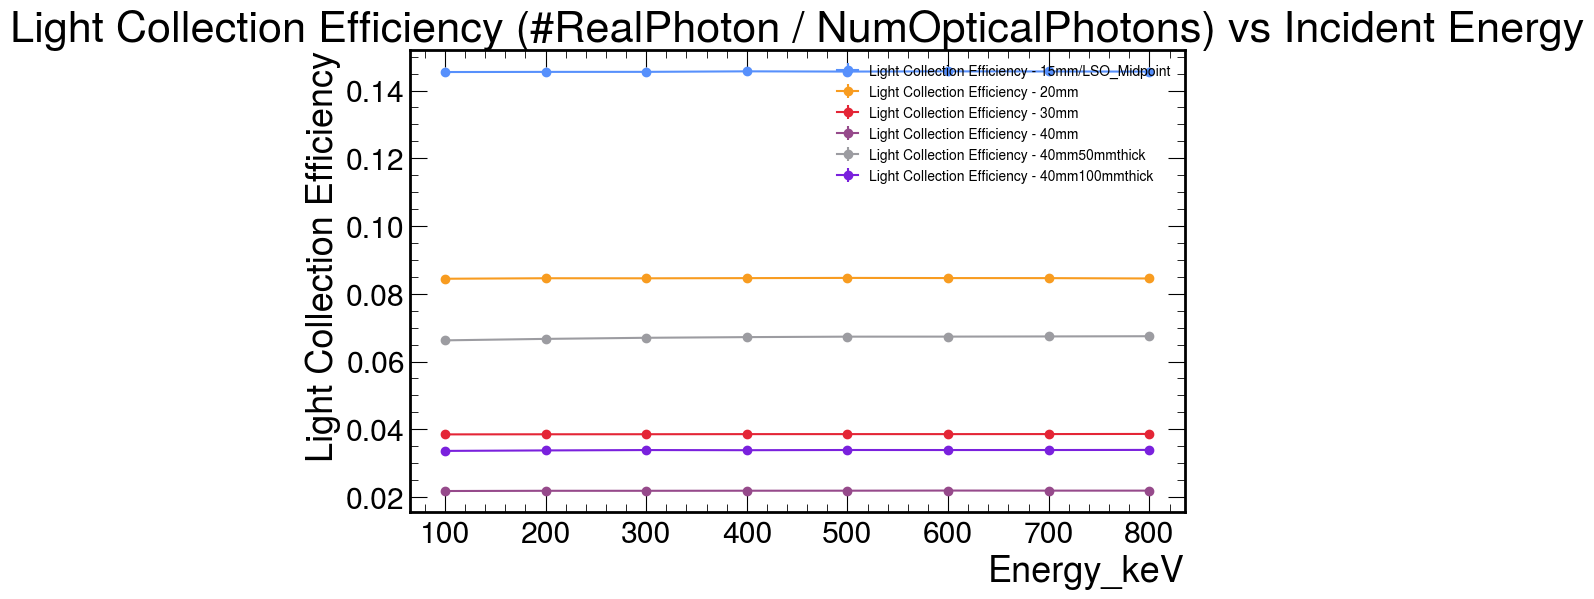

In [53]:
folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]


# Collect light collection efficiency data from all folders
all_eff = {}
all_err = {}
energies_set = set()

for dir_name in folders:
    # Open the combined ROOT file
    with uproot.open(dir_name + '/combined.root') as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        # Read into DataFrames
        edep_df = edep_tree.arrays(library='pd')
        sipm_df = sipm_tree.arrays(library='pd')
    # Merge with EdepCounter (sipm_df is already per-event)
    merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])
    # Get unique energies
    energies = sorted(merged_df['Energy_keV'].unique())
    energies_set.update(energies)
    # Compute efficiencies
    eff_values = []
    err_values = []
    for energy in energies:
        df_energy = merged_df[merged_df['Energy_keV'] == energy]
        real_photon = df_energy['#RealPhoton'].values
        optical_photons = df_energy['NumOpticalPhotons'].values
        eff, err = compute_efficiency_with_error(real_photon, optical_photons)
        eff_values.append(eff)
        err_values.append(err)
    all_eff[dir_name] = eff_values
    all_err[dir_name] = err_values

# Common energies for plotting
common_energies = sorted(list(energies_set))

# Plot all light collection efficiencies in one figure
fig, ax = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    ax.errorbar(common_energies, all_eff[dir_name], yerr=all_err[dir_name], fmt='o-', label=f'Light Collection Efficiency - {dir_name}')
ax.set_xlabel('Energy_keV')
ax.set_ylabel('Light Collection Efficiency')
ax.set_title('Light Collection Efficiency (#RealPhoton / NumOpticalPhotons) vs Incident Energy')
ax.legend(fontsize=10)
plt.show()

# Linearity

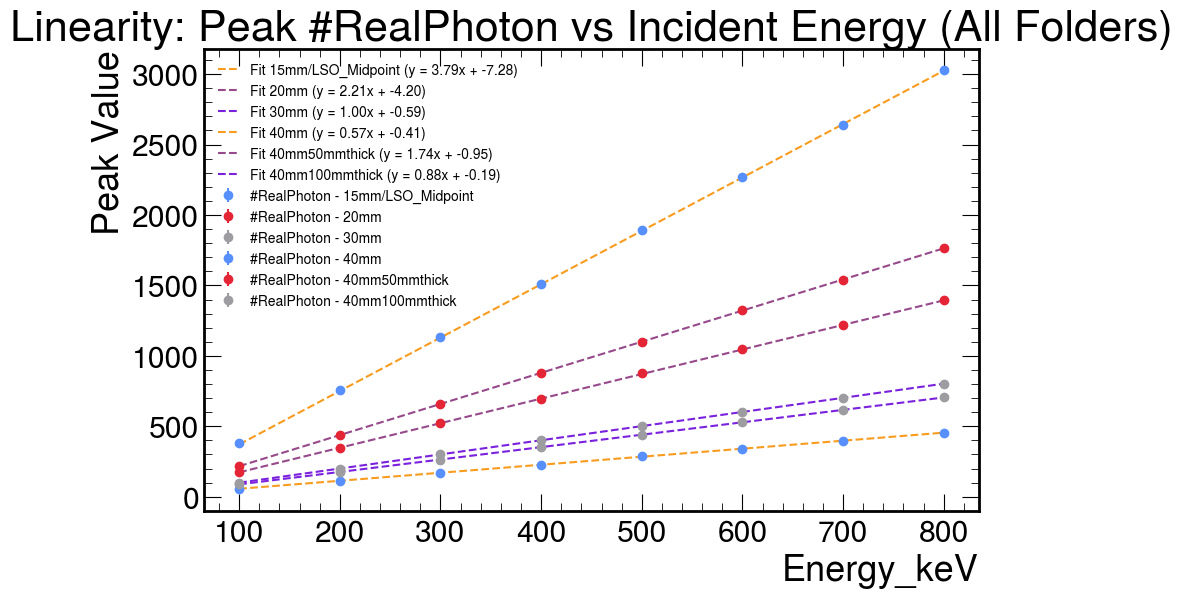

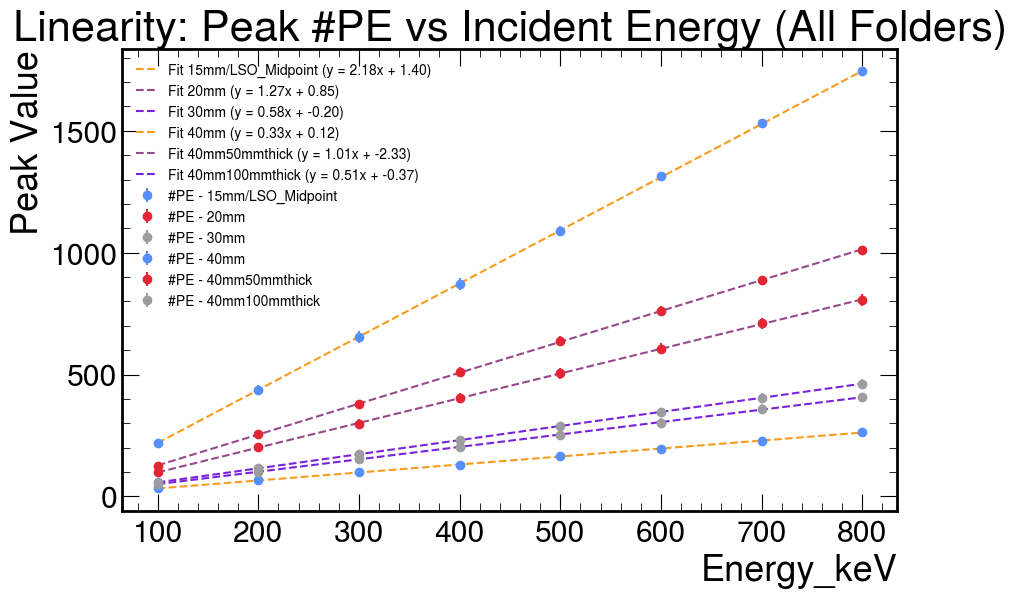

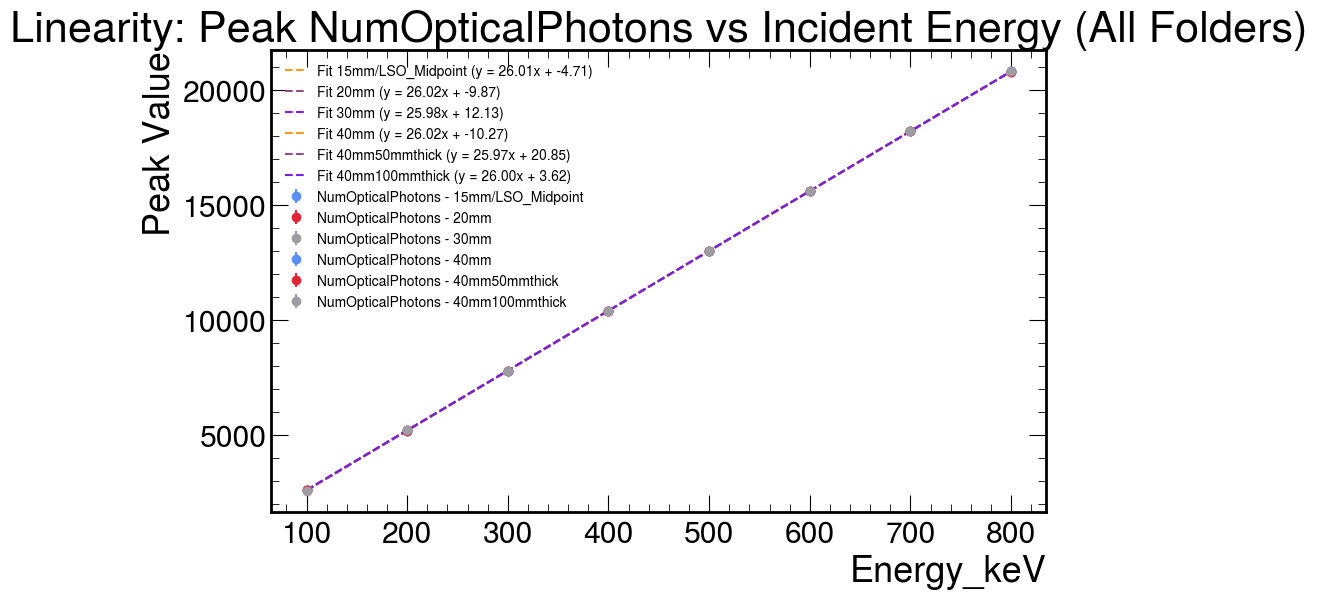

In [ ]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def compute_fwhm_and_peak(values):
    if len(values) == 0:
        return np.nan, np.nan
    min_val = int(values.min())
    max_val = int(values.max())
    bins = np.arange(min_val, max_val + 2)
    hist, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    if hist.max() == 0:
        return np.nan, np.nan
    peak_idx = np.argmax(hist)
    peak = bin_centers[peak_idx]
    half_max = hist.max() / 2.0
    # Find left crossing
    left_cross = bin_centers[0]
    for i in range(peak_idx, 0, -1):
        if hist[i] >= half_max > hist[i-1]:
            frac = (half_max - hist[i-1]) / (hist[i] - hist[i-1])
            left_cross = bin_centers[i-1] + frac * (bin_centers[i] - bin_centers[i-1])
            break
    # Find right crossing
    right_cross = bin_centers[-1]
    for i in range(peak_idx, len(hist) - 1):
        if hist[i] >= half_max > hist[i+1]:
            frac = (half_max - hist[i+1]) / (hist[i] - hist[i+1])
            right_cross = bin_centers[i+1] + frac * (bin_centers[i+1] - bin_centers[i])
            break
    fwhm = right_cross - left_cross
    return peak, fwhm

def compute_peak_and_fwhm_with_error(values, n_bootstrap=100):
    peak_list = []
    fwhm_list = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, len(values), replace=True)
        peak, fwhm = compute_fwhm_and_peak(sample)
        if not np.isnan(peak) and not np.isnan(fwhm):
            peak_list.append(peak)
            fwhm_list.append(fwhm)
    if not peak_list or not fwhm_list:
        return np.nan, np.nan, np.nan
    mean_peak = np.mean(peak_list)
    mean_fwhm = np.mean(fwhm_list)
    err_peak = np.std(peak_list)  # Not used if using FWHM as error bar
    return mean_peak, mean_fwhm, err_peak

def linear_func(x, m, b):
    return m * x + b

folders = ["15mm/LSO_Midpoint", "20mm", "30mm", "40mm","40mm50mmthick","40mm100mmthick"]

# Collect peak and fwhm data from all folders for each variable
all_peak_real = {}
all_peak_pe = {}
all_peak_op = {}
all_fwhm_real = {}
all_fwhm_pe = {}
all_fwhm_op = {}
energies_set = set()

for dir_name in folders:
    # Open the combined ROOT file
    with uproot.open(dir_name + '/combined.root') as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        # Read into DataFrames
        edep_df = edep_tree.arrays(library='pd')
        sipm_df = sipm_tree.arrays(library='pd')
    # Merge with EdepCounter (sipm_df is already per-event)
    merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])
    # Get unique energies
    energies = sorted(merged_df['Energy_keV'].unique())
    energies_set.update(energies)
    # Compute peaks and fwhms
    peak_real = []
    peak_pe = []
    peak_op = []
    fwhm_real = []
    fwhm_pe = []
    fwhm_op = []
    for energy in energies:
        df_energy = merged_df[merged_df['Energy_keV'] == energy]
        peak_rp, fwhm_rp, _ = compute_peak_and_fwhm_with_error(df_energy['#RealPhoton'].values)
        peak_pe_val, fwhm_pe_val, _ = compute_peak_and_fwhm_with_error(df_energy['#PE'].values)
        peak_op_val, fwhm_op_val, _ = compute_peak_and_fwhm_with_error(df_energy['NumOpticalPhotons'].values)
        peak_real.append(peak_rp)
        peak_pe.append(peak_pe_val)
        peak_op.append(peak_op_val)
        fwhm_real.append(fwhm_rp)
        fwhm_pe.append(fwhm_pe_val)
        fwhm_op.append(fwhm_op_val)
    all_peak_real[dir_name] = peak_real
    all_peak_pe[dir_name] = peak_pe
    all_peak_op[dir_name] = peak_op
    all_fwhm_real[dir_name] = fwhm_real
    all_fwhm_pe[dir_name] = fwhm_pe
    all_fwhm_op[dir_name] = fwhm_op

# Common energies for plotting
common_energies = sorted(list(energies_set))

# Plot linearity for #RealPhoton
fig_real, ax_real = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    peaks = np.array(all_peak_real[dir_name])
    fwhms = np.array(all_fwhm_real[dir_name])
    valid_mask = ~np.isnan(peaks) & ~np.isnan(fwhms)
    ax_real.errorbar(np.array(common_energies)[valid_mask], peaks[valid_mask], yerr=fwhms[valid_mask]/2, fmt='o', label=f'#RealPhoton - {dir_name}')
    # Linear fit (using peaks, weighted by 1/(fwhm/2)^2)
    if np.sum(valid_mask) >= 2:
        x_data = np.array(common_energies)[valid_mask]
        y_data = peaks[valid_mask]
        y_err = fwhms[valid_mask]/2
        popt, pcov = curve_fit(linear_func, x_data, y_data, sigma=y_err, absolute_sigma=True)
        fit_line = linear_func(np.array(common_energies), *popt)
        ax_real.plot(common_energies, fit_line, '--', label=f'Fit {dir_name} (y = {popt[0]:.2f}x + {popt[1]:.2f})')
ax_real.set_xlabel('Energy_keV')
ax_real.set_ylabel('Peak Value')
ax_real.set_title('Linearity: Peak #RealPhoton vs Incident Energy')
ax_real.legend(fontsize=10)
plt.show()

# Plot linearity for #PE
fig_pe, ax_pe = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    peaks = np.array(all_peak_pe[dir_name])
    fwhms = np.array(all_fwhm_pe[dir_name])
    valid_mask = ~np.isnan(peaks) & ~np.isnan(fwhms)
    ax_pe.errorbar(np.array(common_energies)[valid_mask], peaks[valid_mask], yerr=fwhms[valid_mask]/2, fmt='o', label=f'#PE - {dir_name}')
    # Linear fit (using peaks, weighted by 1/(fwhm/2)^2)
    if np.sum(valid_mask) >= 2:
        x_data = np.array(common_energies)[valid_mask]
        y_data = peaks[valid_mask]
        y_err = fwhms[valid_mask]/2
        popt, pcov = curve_fit(linear_func, x_data, y_data, sigma=y_err, absolute_sigma=True)
        fit_line = linear_func(np.array(common_energies), *popt)
        ax_pe.plot(common_energies, fit_line, '--', label=f'Fit {dir_name} (y = {popt[0]:.2f}x + {popt[1]:.2f})')
ax_pe.set_xlabel('Energy_keV')
ax_pe.set_ylabel('Peak Value')
ax_pe.set_title('Linearity: Peak #PE vs Incident Energy')
ax_pe.legend(fontsize=10)
plt.show()

# Plot linearity for NumOpticalPhotons
fig_op, ax_op = plt.subplots(figsize=(10, 6))
for dir_name in folders:
    peaks = np.array(all_peak_op[dir_name])
    fwhms = np.array(all_fwhm_op[dir_name])
    valid_mask = ~np.isnan(peaks) & ~np.isnan(fwhms)
    ax_op.errorbar(np.array(common_energies)[valid_mask], peaks[valid_mask], yerr=fwhms[valid_mask]/2, fmt='o', label=f'NumOpticalPhotons - {dir_name}')
    # Linear fit (using peaks, weighted by 1/(fwhm/2)^2)
    if np.sum(valid_mask) >= 2:
        x_data = np.array(common_energies)[valid_mask]
        y_data = peaks[valid_mask]
        y_err = fwhms[valid_mask]/2
        popt, pcov = curve_fit(linear_func, x_data, y_data, sigma=y_err, absolute_sigma=True)
        fit_line = linear_func(np.array(common_energies), *popt)
        ax_op.plot(common_energies, fit_line, '--', label=f'Fit {dir_name} (y = {popt[0]:.2f}x + {popt[1]:.2f})')
ax_op.set_xlabel('Energy_keV')
ax_op.set_ylabel('Peak Value')
ax_op.set_title('Linearity: Peak NumOpticalPhotons vs Incident Energy')
ax_op.legend(fontsize=10)
plt.show()

# Detector size estimation

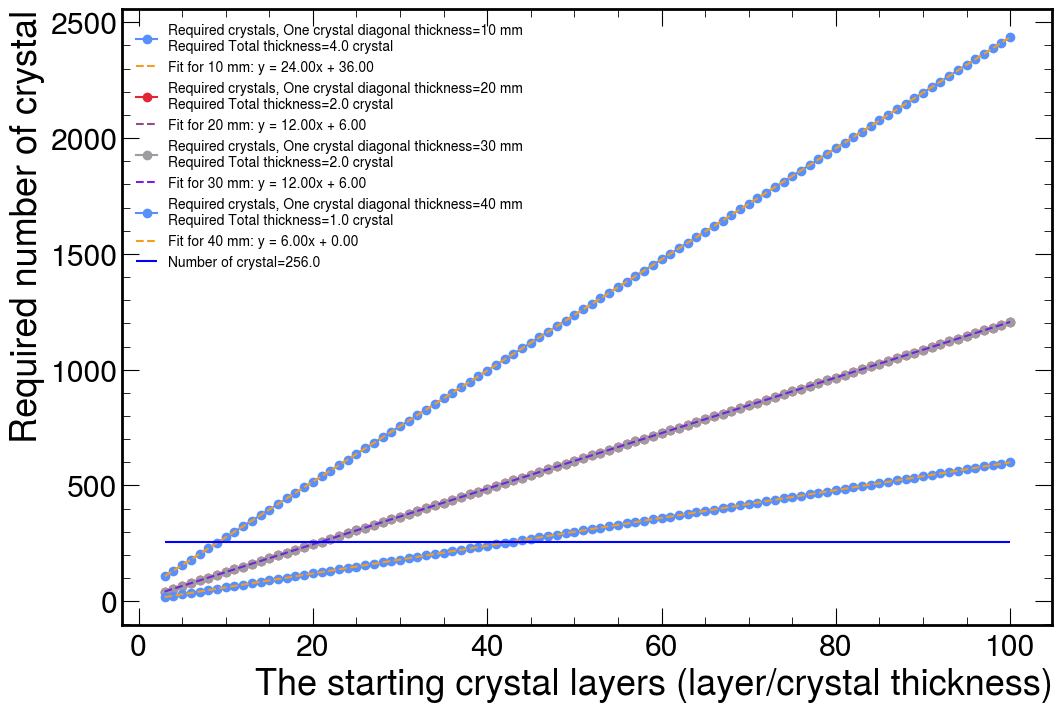

In [45]:
def Crystal_number_estimate(inner_radius=[400], crystal_dim=100, require_stopping_distance=35):  # units in mm
    Count = []
    for ir in inner_radius:
        inner_radi = np.ceil(ir / crystal_dim).astype(int)
        thickness = np.ceil(require_stopping_distance / crystal_dim).astype(int)
        counter = 0
        S = lambda n: 6 * n  # n>=1, the origin layer is 0, then starting to second layer, it is 6*(n-1) edge+6 corner= 6n
        for i in range(inner_radi, inner_radi + thickness):
            counter += S(i)
        Count.append(counter)
    return np.array(Count)

crystal_sizes = [10,20,30,40]
min_layer = 3
max_layer = 100
x = np.arange(min_layer, max_layer + 1)

fig, ax1 = plt.subplots(figsize=(12, 8))

for crystal_size in crystal_sizes:
    inner_radius = x * crystal_size
    y = Crystal_number_estimate(inner_radius=inner_radius, crystal_dim=crystal_size)
    ax1.plot(x, y, "o-", label=f"Required crystals, One crystal diagonal thickness={crystal_size} mm"+"\n" +f"Required Total thickness={np.ceil(35/crystal_size)} crystal")

    # Fit a straight line
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    ax1.plot(x, y_fit, "--", label=f"Fit for {crystal_size} mm: y = {slope:.2f}x + {intercept:.2f}")

ax1.hlines(1024 / 4, min_layer, max_layer, color="b", label=f"Number of crystal={1024/4}", linestyles="-")
ax1.set_xlabel("The starting crystal layers (layer/crystal thickness)")
ax1.set_ylabel("Required number of crystal")

ax1.legend(fontsize=10)

plt.show()